In [3]:
from scipy import stats, special, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pymc3 as pm
import arviz as az
import pandas as pd
from theano import shared
from theano import tensor as T
import seaborn as sns
from scipy.special import expit as logistic
import statsmodels as sm
from statsmodels.graphics import tsaplots as smplots
import warnings
import theano
import theano.tensor as tt
from scipy.special import expit as logistic
import seaborn as sns

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import statsmodels as stm

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

# 1. EDA

In [4]:
prison = pd.read_csv('/home/mach1ne/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

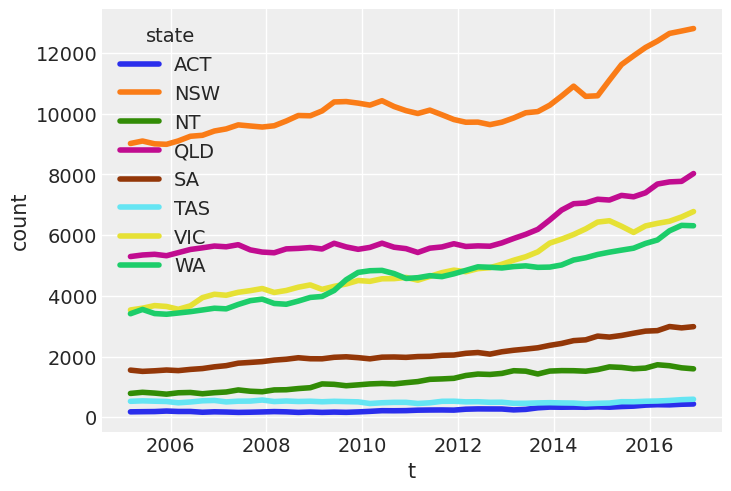

In [5]:
# Prison count by state
prison_state = prison.groupby(['t','state'])['count'].sum().reset_index()
sns.lineplot(data=prison_state, x = "t", y = "count", hue = "state");

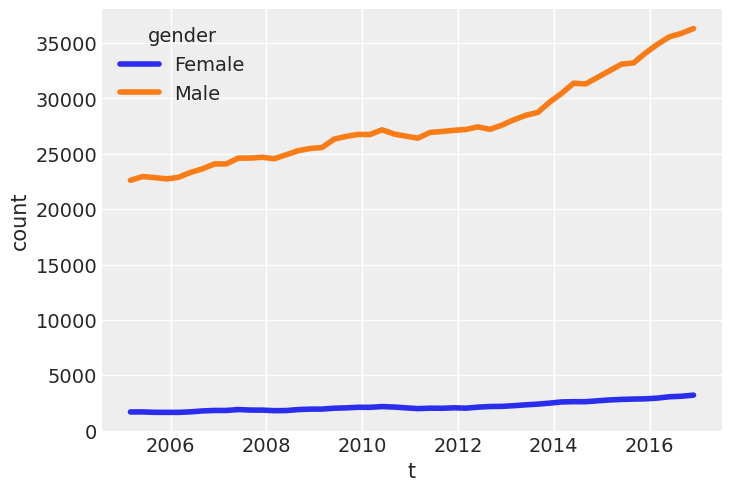

In [6]:
# Prison count by gender
prison_gender = prison.groupby(['t','gender'])['count'].sum().reset_index()
sns.lineplot(data=prison_gender, x = "t", y = "count", hue = "gender");

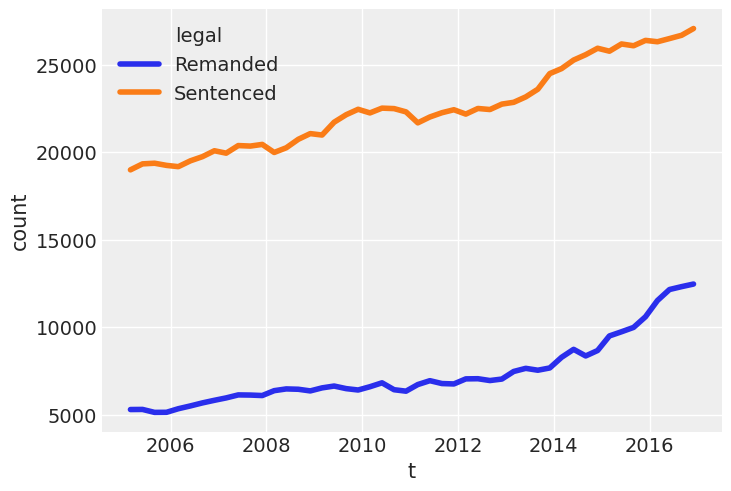

In [7]:
# Prison count by legal
prison_legal = prison.groupby(['t','legal'])['count'].sum().reset_index()
sns.lineplot(data=prison_legal, x = "t", y = "count", hue = "legal");

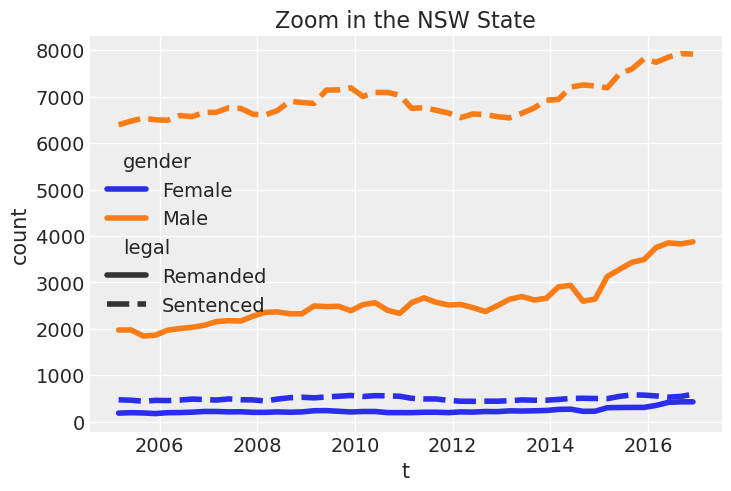

In [8]:
# Zoom in the NSW state
sns.lineplot(data=prison.query("state == 'NSW'"), x = "t", y = "count", hue = "gender", style="legal").set_title("Zoom in the NSW State");

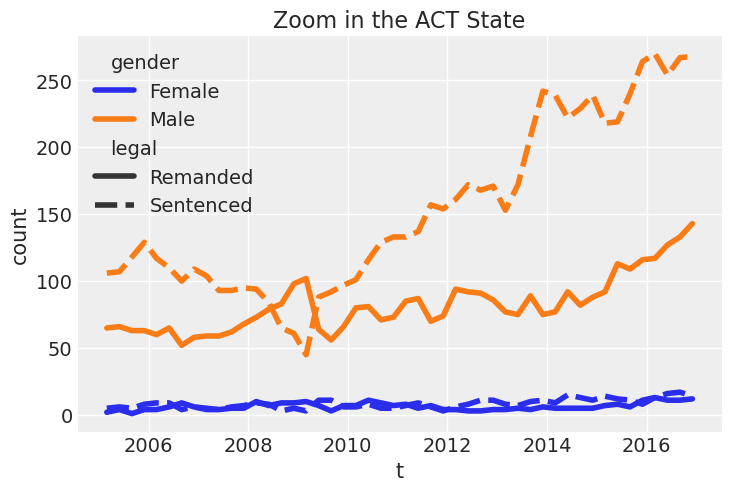

In [9]:
# Zoom in the ACT state
sns.lineplot(data=prison.query("state == 'ACT'"), x = "t", y = "count", hue = "gender", style="legal").set_title("Zoom in the ACT State");

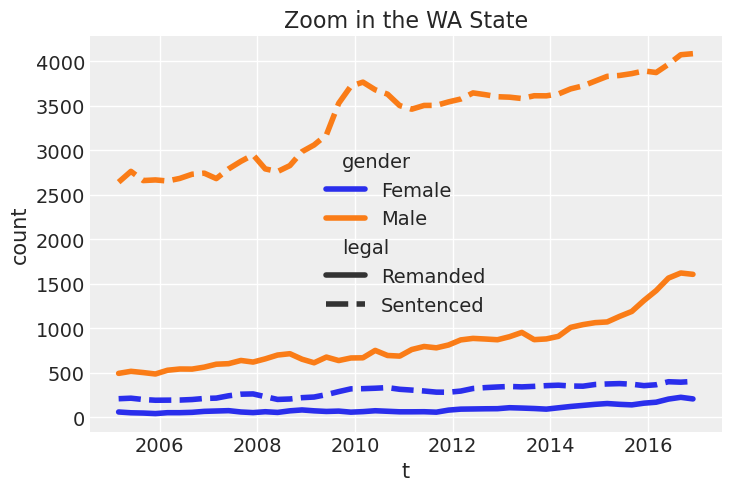

In [10]:
# Zoom in the WA state
sns.lineplot(data=prison.query("state == 'WA'"), x = "t", y = "count", hue = "gender", style="legal").set_title("Zoom in the WA State");

## 1.1 Time series decomposition

In [11]:
prison_NSW = prison[prison['state'] == 'NSW'].groupby(['t'])['count'].sum()
prison_NSW = prison_NSW.reset_index().set_index('t')

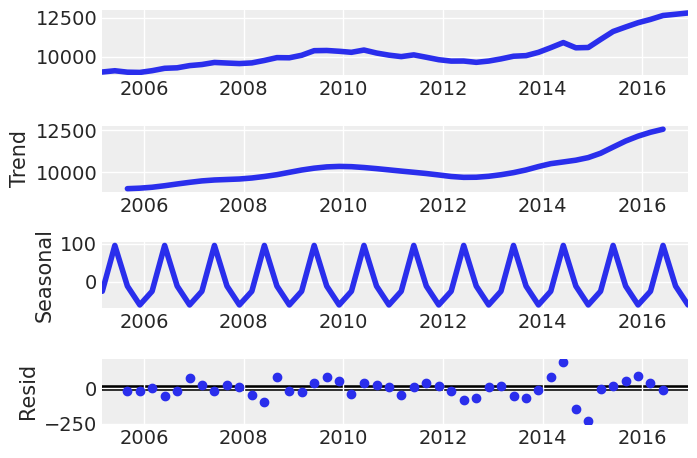

In [12]:
decomposition = sm.tsa.seasonal_decompose(prison_NSW, model='additive')
fig = decomposition.plot()
plt.show()

In [13]:
decomposition.seasonal

t
2005-03-01   -24.397727
2005-06-01    95.306818
2005-09-01   -10.829545
2005-12-01   -60.079545
2006-03-01   -24.397727
2006-06-01    95.306818
2006-09-01   -10.829545
2006-12-01   -60.079545
2007-03-01   -24.397727
2007-06-01    95.306818
2007-09-01   -10.829545
2007-12-01   -60.079545
2008-03-01   -24.397727
2008-06-01    95.306818
2008-09-01   -10.829545
2008-12-01   -60.079545
2009-03-01   -24.397727
2009-06-01    95.306818
2009-09-01   -10.829545
2009-12-01   -60.079545
2010-03-01   -24.397727
2010-06-01    95.306818
2010-09-01   -10.829545
2010-12-01   -60.079545
2011-03-01   -24.397727
2011-06-01    95.306818
2011-09-01   -10.829545
2011-12-01   -60.079545
2012-03-01   -24.397727
2012-06-01    95.306818
2012-09-01   -10.829545
2012-12-01   -60.079545
2013-03-01   -24.397727
2013-06-01    95.306818
2013-09-01   -10.829545
2013-12-01   -60.079545
2014-03-01   -24.397727
2014-06-01    95.306818
2014-09-01   -10.829545
2014-12-01   -60.079545
2015-03-01   -24.397727
2015-06-01    

In [14]:
decomposition.trend

t
2005-03-01          NaN
2005-06-01          NaN
2005-09-01     9039.375
2005-12-01     9069.625
2006-03-01     9124.375
2006-06-01     9214.250
2006-09-01     9318.375
2006-12-01     9414.625
2007-03-01     9499.750
2007-06-01     9554.375
2007-09-01     9583.750
2007-12-01     9612.750
2008-03-01     9672.000
2008-06-01     9761.625
2008-09-01     9869.125
2008-12-01    10008.625
2009-03-01    10144.375
2009-06-01    10253.875
2009-09-01    10329.875
2009-12-01    10358.875
2010-03-01    10343.625
2010-06-01    10292.250
2010-09-01    10226.750
2010-12-01    10153.500
2011-03-01    10080.750
2011-06-01    10010.125
2011-09-01     9937.500
2011-12-01     9852.125
2012-03-01     9762.125
2012-06-01     9710.625
2012-09-01     9717.375
2012-12-01     9773.500
2013-03-01     9865.750
2013-06-01     9989.500
2013-09-01    10149.625
2013-12-01    10349.250
2014-03-01    10521.500
2014-06-01    10623.000
2014-09-01    10727.375
2014-12-01    10881.875
2015-03-01    11137.625
2015-06-01    

## 1.2 Model fitting with ARIMA

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
all_results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(prison_NSW,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            all_results.append([param, param_seasonal, results.aic])
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1004.1307036111918
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:953.0843374691915
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:601.3389058296673
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:402.8821222049159
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:601.9305678994049
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:692.1210983100746
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:415.5519266385286
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:392.8724045681669
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:952.7858326258304
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3730.7061488798504
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:547.7182349799803
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:360.8993365240597
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:570.2342935363464
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1433148737.292445
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:392.4228324179014
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:362.81647901810834
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:614.8809303041113
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1306.762401254247
ARIMA(0

In [17]:
def sort_sublist(sub_li, i): 
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    sub_li.sort(key = lambda x: x[i]) 
    return sub_li 

In [18]:
# Best result
sort_sublist(all_results, 2)[0]

[(0, 1, 1), (1, 1, 1, 12), 279.5848396035702]

In [19]:
mod = sm.tsa.statespace.SARIMAX(prison_NSW,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0000     42.274      0.024      0.981     -81.855      83.855
ar.S.L12       0.0660      0.028      2.328      0.020       0.010       0.122
ma.S.L12      -1.0084     41.934     -0.024      0.981     -83.197      81.180
sigma2       1.61e+04      0.003   6.12e+06      0.000    1.61e+04    1.61e+04


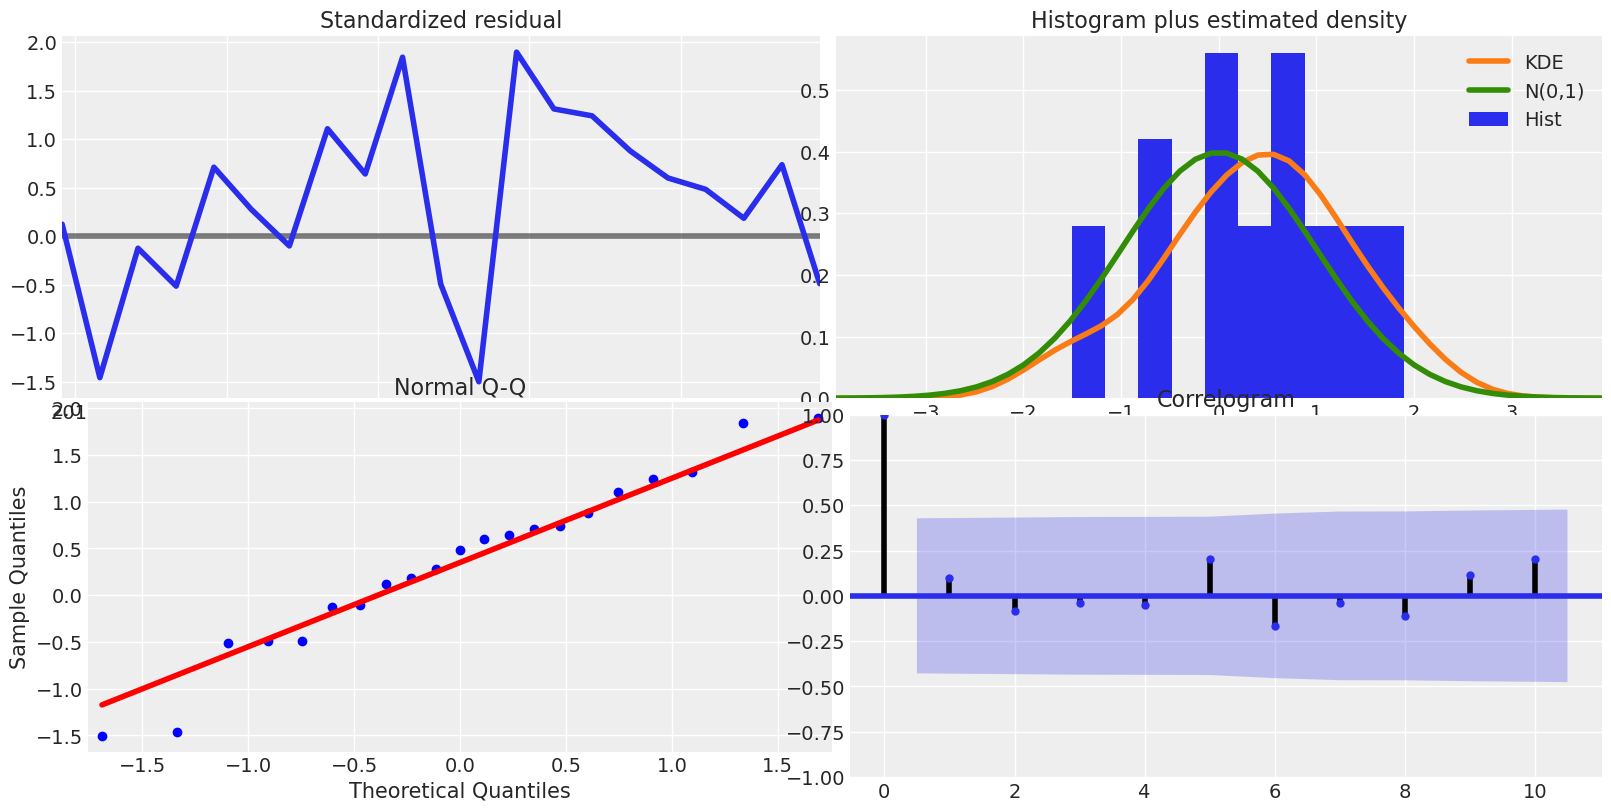

In [20]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## 1.3 Forecasting

In [21]:
from datetime import datetime

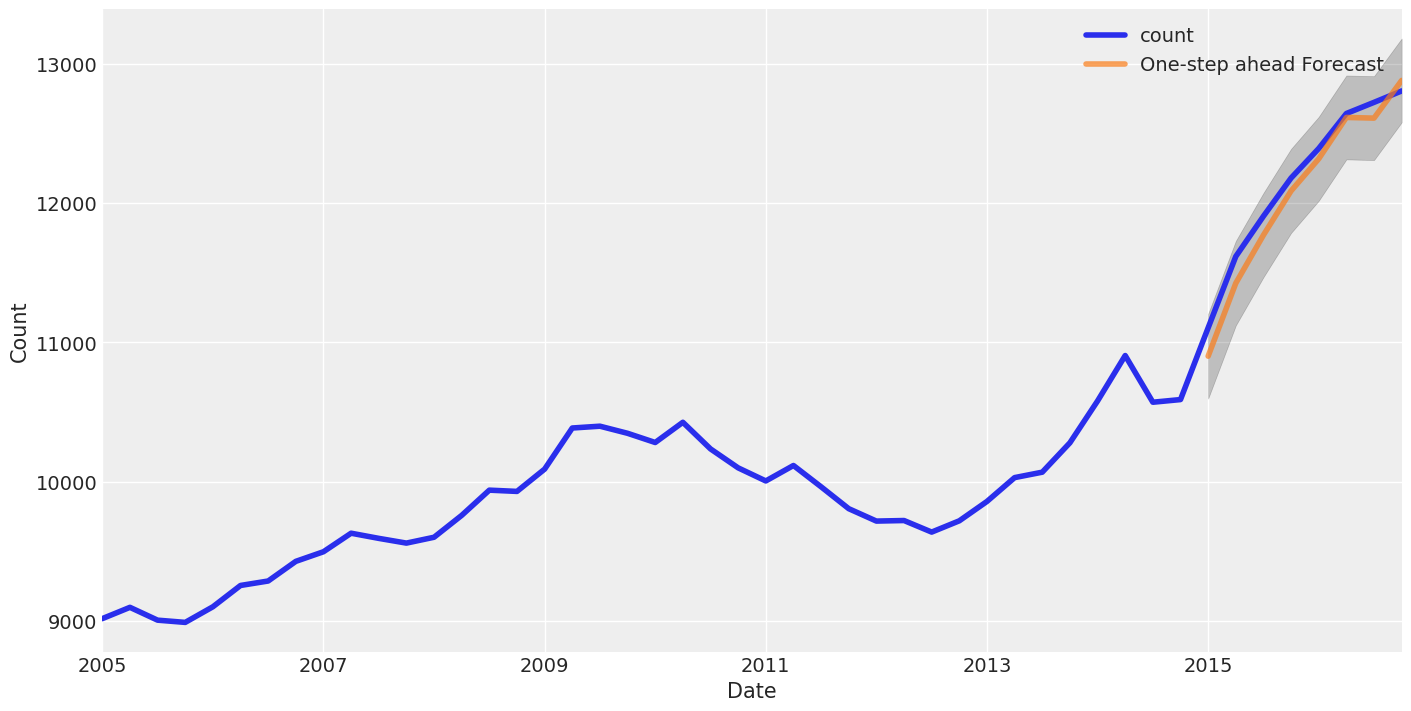

In [22]:
pred = results.get_prediction(start=datetime(2015, 3, 1), dynamic=False)
pred_ci = pred.conf_int()
ax = prison_NSW['2005':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.legend()
plt.show()

In [23]:
y_forecasted = pred.predicted_mean
y = prison_NSW['2015-03-01':]
mse = ((y_forecasted.values - y.values.T) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 16238.76


In [24]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 127.43


## 1.4 Producing and visualizing forecasts

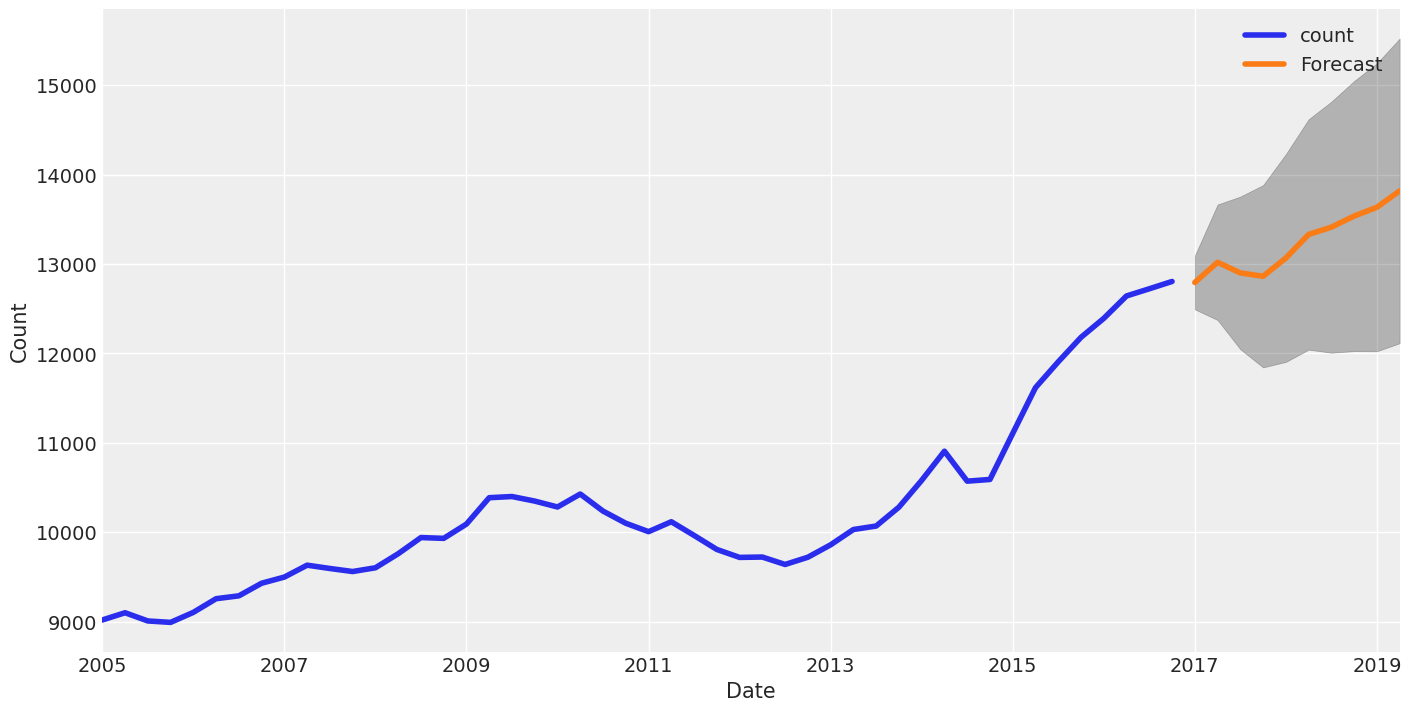

In [25]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax =prison_NSW.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.legend()
plt.show()

# 2. Our Model

## 2.1 Model Definition

ADD HERE THE STATE SPACE EQUATIONS!!!!


### 2.1.1 Model structure

1. Hyperprior level 0: All
2. Hyperprior level 1: state, gender, legal
3. Adaptative priors
4. Latent process
5. Likelihood

### 2.1.2 Modeling groups


state -> s, gender -> g, legal -> l

$$\begin{aligned}
Y_{t,i} = \beta_0& \;\;\;\quad\quad\qquad\qquad\qquad\qquad\qquad\qquad \textrm{baseline} \\ 
&+\sum_s{\beta_{1,s} x_{1,s}} + \sum_g{\beta_{2,g} x_{2,g}} + \sum_l{\beta_{3,l} x_{3,l}} \;\textrm{group effects}\\ &+\beta_{4} * Y_{t-1} \qquad\qquad\qquad\qquad\qquad\;\;\textrm{AR effect - covariate} \\
&+ \epsilon \qquad\qquad\qquad\qquad\qquad\qquad\;\quad \textrm{error term} \end{aligned}$$


#### 2.1.2.1 Define constraints to the deflections (effects):

We want the predicted value to be a baseline plus a deflection due to the level of factor 1 plus a deflection due to the level of factor 2, etc.

$$\sum_s\beta_{1,s} = 0$$
$$\sum_g\beta_{2,g} = 0$$
$$\sum_l\beta_{3,l} = 0$$

So,

$$\begin{aligned}
&\beta_0 +\sum_s{\beta_{1,s} x_{1,s}} + \sum_g{\beta_{2,g} x_{2,g}} + \sum_l{\beta_{3,l} x_{3,l}} +\beta_{4} * x_{cov} \\
&= \alpha_0 + \bar \alpha - \alpha_{cov} \bar x_{cov} + \sum_s{(\alpha_s - \bar \alpha)x_s} + \sum_g{(\alpha_g - \bar \alpha)x_g} + \sum_l{(\alpha_l - \bar \alpha)x_l} + \alpha_{cov} x_{cov}
\end{aligned}$$

where $\bar \alpha = \frac{1}{S} \sum^{S}_{s=1} \alpha_s + \frac{1}{G} \sum^{G}_{g=1} \alpha_g + \frac{1}{L} \sum^{L}_{l=1}\alpha_{l}$

In our case $x_{cov} = y_{t-1}$, since we are defining an autoregressive process.

Describe the method that uses the cell structure to derive the coefficients (overall mean, marginal means, etc).
$$\begin{aligned}
\beta_0 &= \alpha_0 +  \bar \alpha - \alpha_{cov} \bar x_{cov} \\
\beta_1 &= \frac{1}{S} \sum_s (\alpha_s - \bar \alpha) \\
\beta_2 &= \frac{1}{G} \sum_g (\alpha_g - \bar \alpha) \\
\beta_3 &= \frac{1}{L} \sum_l (\alpha_l - \bar \alpha) \\
\beta_{cov} &= \alpha_{cov}
\end{aligned}$$

Do the same for interactions.


In [134]:
X = np.tile(np.arange(NSW.shape[0]).reshape(NSW.shape[0],1), (1,2))
y = NSW_WA.values

In [30]:
from pymc3.distributions import distribution
from pymc3.distributions.continuous import get_tau_sigma, Normal, Flat

class AR(distribution.Continuous):

    def __init__(self, k, tau_e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k = tt.as_tensor_variable(k)
        self.tau_e = tau_e = tt.as_tensor_variable(tau_e)
        self.tau = tau_e * (1 - k ** 2)
        self.mode = tt.as_tensor_variable(0.0)

    def logp(self, x):
        k = self.k
        tau_e = self.tau_e  # innovation precision
    
        x_im1 = x[:-1]
        x_i = x[1:]
        boundary = Normal.dist(0.0, tau=tau_e).logp

        innov_like = Normal.dist(k * x_im1, tau=tau_e).logp(x_i)
        return boundary(x[0]) + tt.sum(innov_like)

## 2.2 End-to-end forecasting process with single series and a probabilistic state space approach

In [138]:
X = np.arange(48)

# Trend value could be around
(decomposition.trend[-3] - decomposition.trend[3])/(48-3-3)

83.16666666666667

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 34100
Interrupted at 34,099 [17%]: Average Loss = 1.1435e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_pre, tau, phi, b, a]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 10 seconds.


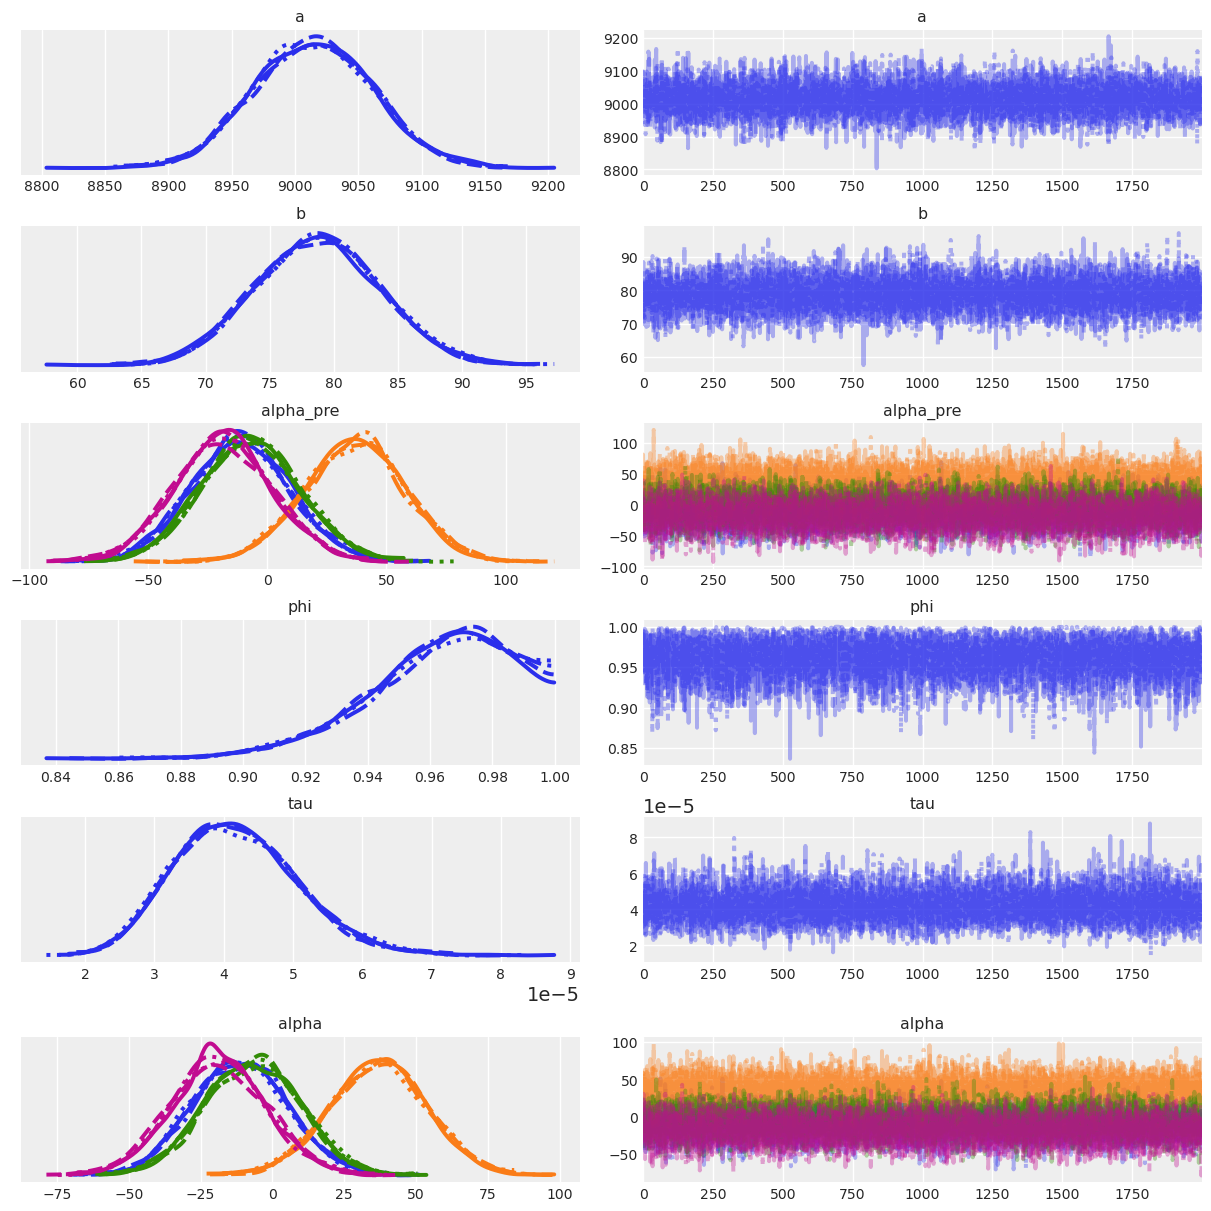

In [32]:
# trend + seasonality + AR(1) errors

y_ = shared(y[:,0])
with pm.Model() as model:
    a = pm.Normal("a",y[0,0], 50)
    b = pm.Normal("b",80, 5)

    # Regularizing prior for phi
    phi = pm.Bound(pm.Laplace, lower = -1, upper=1)("phi", 0.0, 0.05)
    tau = pm.HalfNormal("tau", 1)
    
    alpha_pre = pm.Normal('alpha_pre', 0, 25, shape=4)
    alpha = pm.Deterministic('alpha', alpha_pre - tt.mean(alpha_pre,axis=0))
    seasonality = alpha[np.arange(y.shape[0])%4]
    
    
    mu = a + X * b + seasonality

    err = y_- mu
    y_pred = AR("y_pred", k=phi, tau_e=tau, observed=err)
    trace = pm.sample(draws=2000, 
                      tune=4000, 
                      init="advi+adapt_diag",
                      target_accept=0.90)

pm.plots.traceplot(trace);

In [33]:
az.summary(trace, var_names=['~alpha-pre'])

mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
a             9014.622  47.355  8927.037  9103.914      0.464    0.328   
b               78.807   4.812    70.111    87.973      0.048    0.034   
alpha_pre[0]   -11.375  20.749   -49.543    28.485      0.223    0.213   
alpha_pre[1]    36.811  21.027    -2.999    75.356      0.220    0.171   
alpha_pre[2]    -6.899  20.686   -45.440    32.526      0.207    0.219   
alpha_pre[3]   -18.670  20.604   -54.877    22.292      0.220    0.181   
phi              0.963   0.023     0.923     1.000      0.000    0.000   
tau              0.000   0.000     0.000     0.000      0.000    0.000   
alpha[0]       -11.342  16.501   -41.867    19.456      0.152    0.158   
alpha[1]        36.844  16.969     4.843    68.380      0.169    0.132   
alpha[2]        -6.866  16.555   -36.926    24.811      0.150    0.176   
alpha[3]       -18.637  16.550   -50.228    12.253      0.156    0.134   

              ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
a              10418.0  10418.0   10438.0    6081.0    1.0  
b               9881.0   9772.0    9916.0    6047.0    1.0  
alpha_pre[0]    8622.0   4767.0    8615.0    5646.0    1.0  
alpha_pre[1]    9160.0   7563.0    9126.0    6081.0    1.0  
alpha_pre[2]    9962.0   4475.0    9962.0    6276.0    1.0  
alpha_pre[3]    8810.0   6480.0    8818.0    6635.0    1.0  
phi             6410.0   6317.0    4732.0    2969.0    1.0  
tau             9822.0   9709.0    9591.0    5999.0    1.0  
alpha[0]       11810.0   5447.0   11789.0    6138.0    1.0  
alpha[1]       10077.0   8264.0   10053.0    5690.0    1.0  
alpha[2]       12125.0   4416.0   12160.0    5981.0    1.0  
alpha[3]       11220.0   7582.0   11235.0    6522.0    1.0

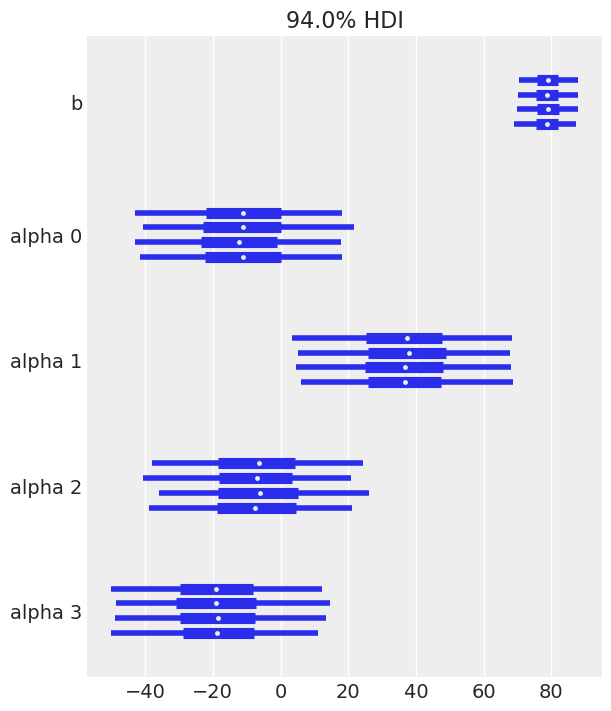

In [34]:
pm.forestplot(trace, var_names=['~alpha_pre', '~a', '~phi', '~tau']);

### 2.2.1 Checking correlations between parameters

In [35]:
df_trace = pm.trace_to_dataframe(trace)
df_trace = df_trace[['a', 'b', 'phi', 'tau', 'alpha__0', 'alpha__1', 'alpha__2', 'alpha__3']]

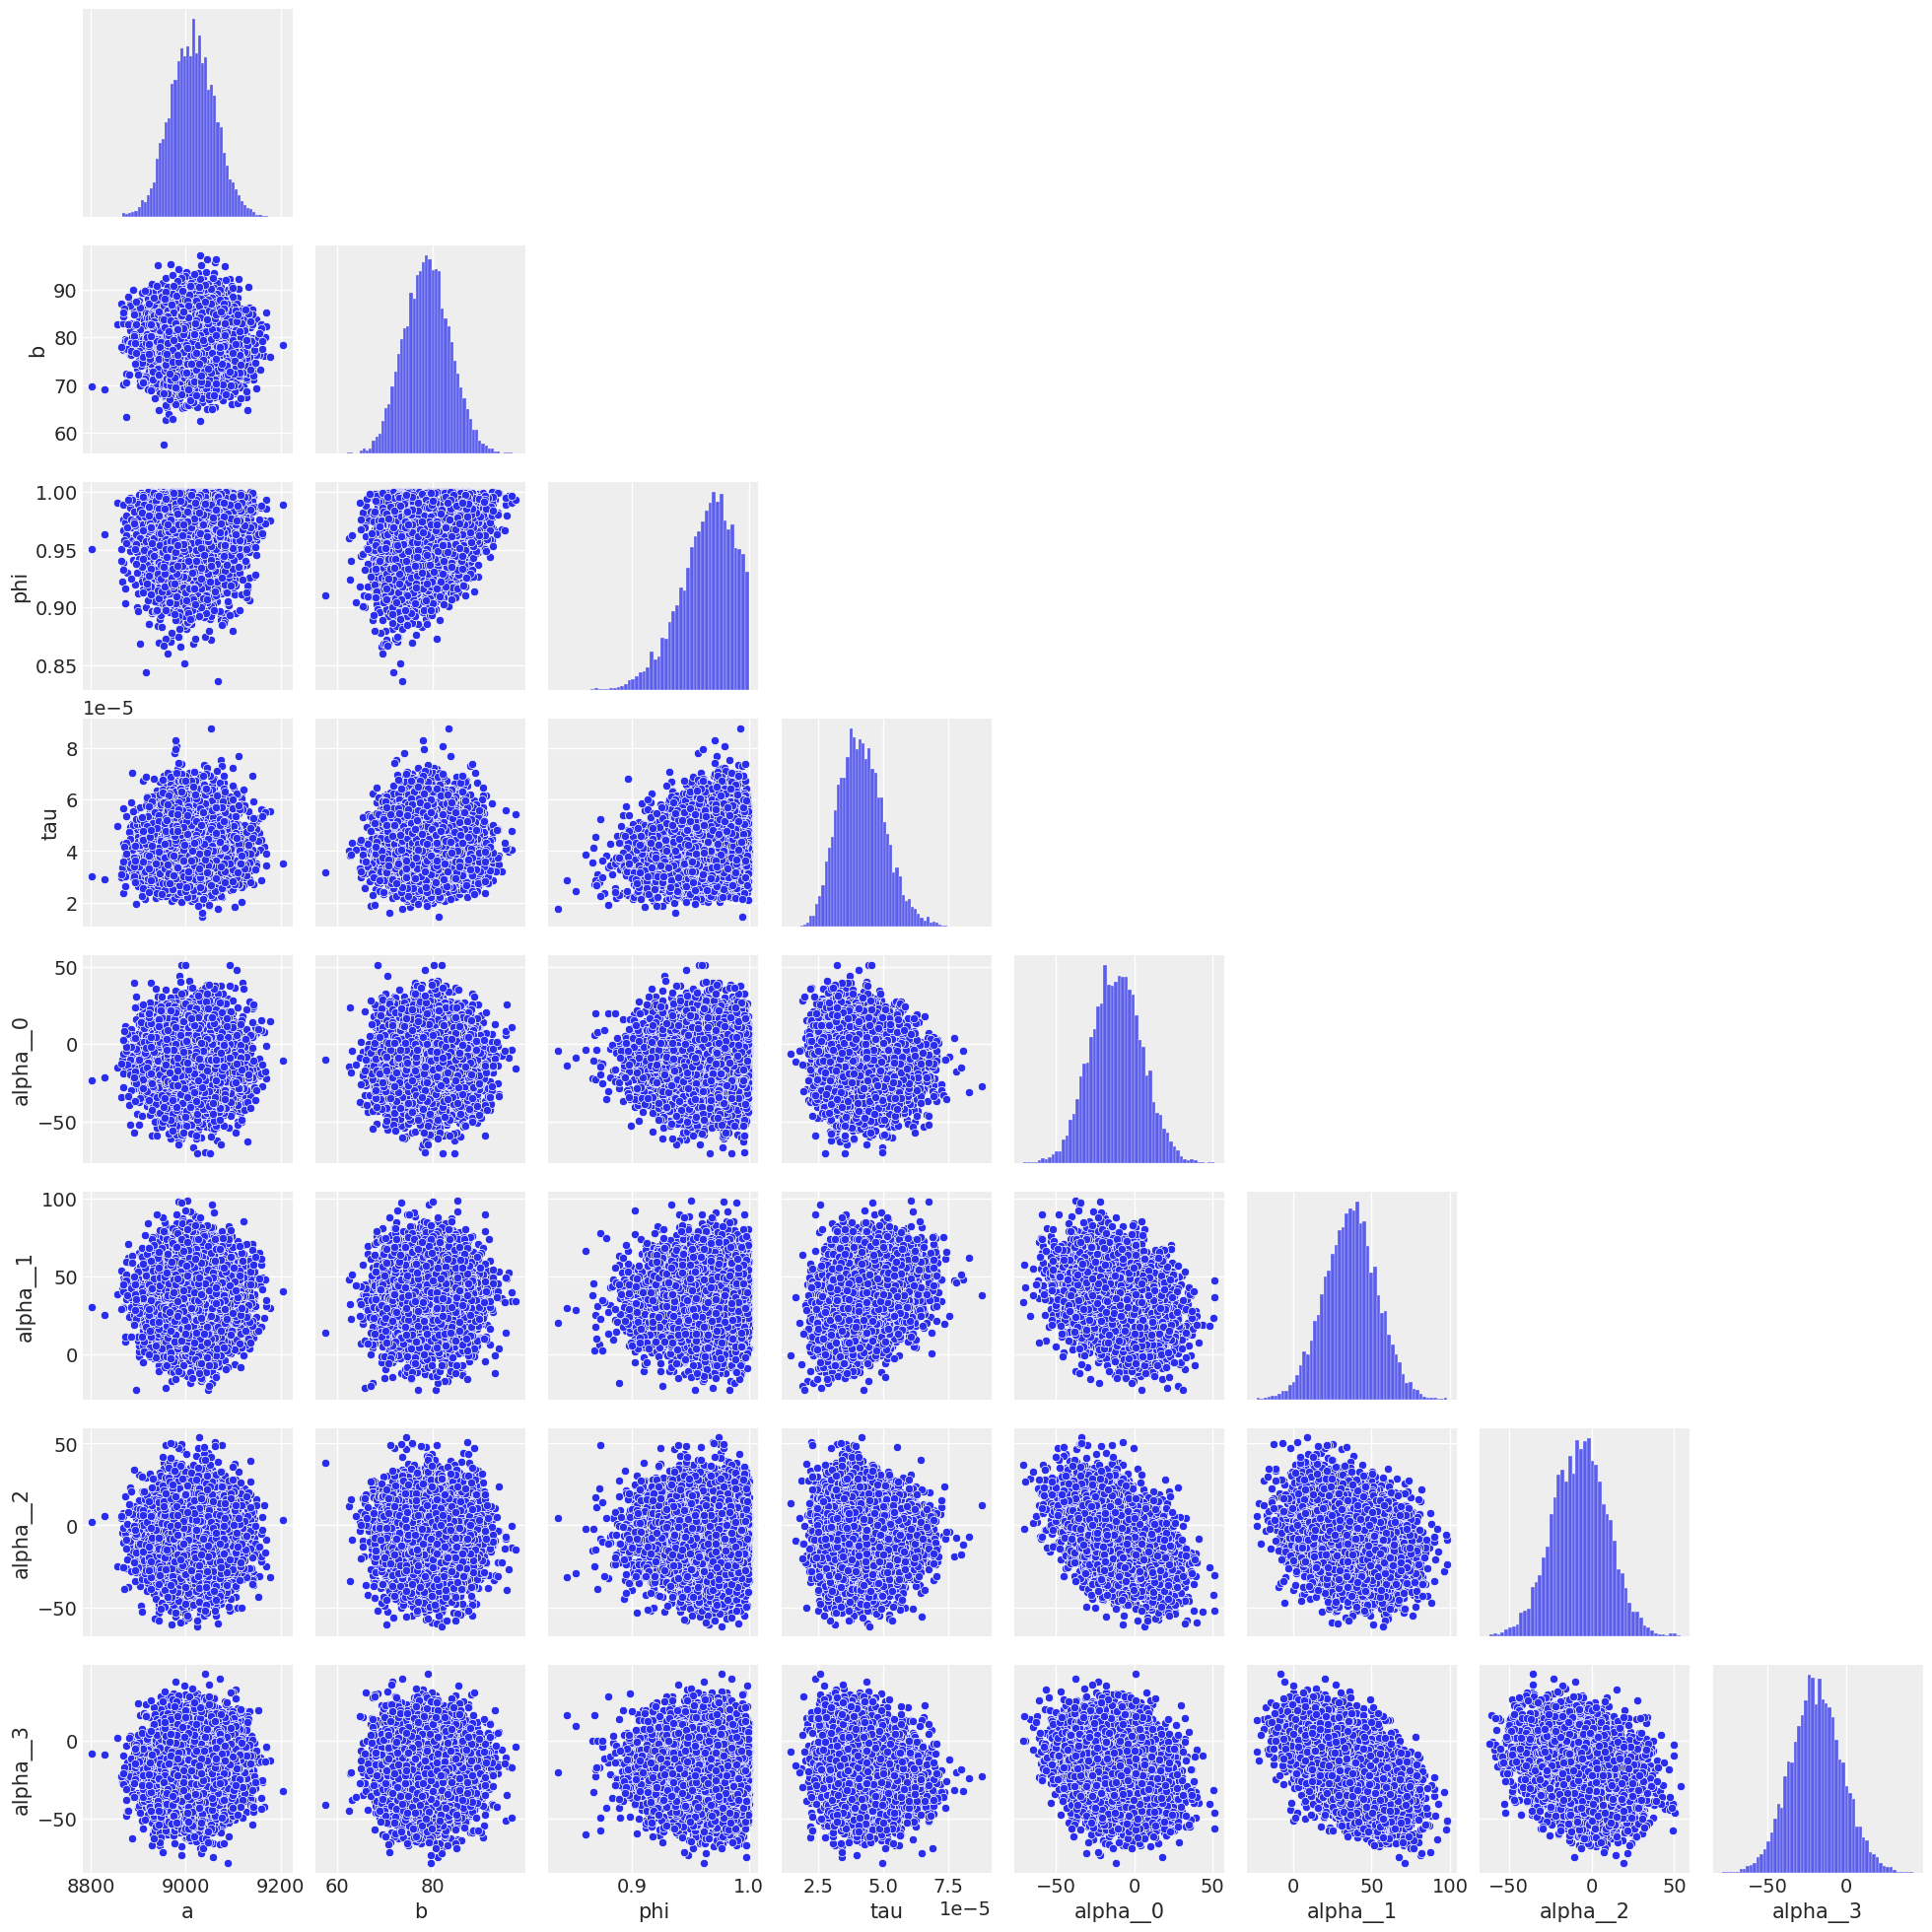

In [36]:
sns.pairplot(df_trace, corner=True);

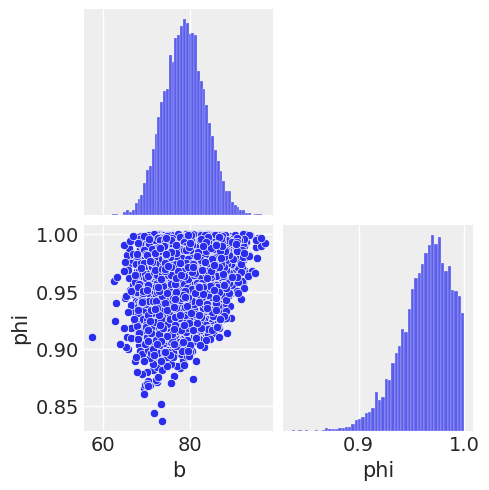

In [76]:
sns.pairplot(df_trace[['b', 'phi']], corner=True);

In [126]:
y_ = df_trace['phi']
X_ = df_trace['b']
X_ = sm.add_constant(X_)

model = sm.OLS(y_, X_)
results = model.fit()

In [127]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    phi   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     562.5
Date:                Sun, 08 Nov 2020   Prob (F-statistic):          3.22e-120
Time:                        16:15:05   Log-Likelihood:                 19018.
No. Observations:                8000   AIC:                        -3.803e+04
Df Residuals:                    7998   BIC:                        -3.802e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8658      0.004    210.164      0.0

In [128]:
results.summary2().tables[1]

Coef.  Std.Err.           t          P>|t|    [0.025    0.975]
const  0.865821  0.004120  210.163629   0.000000e+00  0.857746  0.873897
b      0.001237  0.000052   23.716154  3.223990e-120  0.001135  0.001340

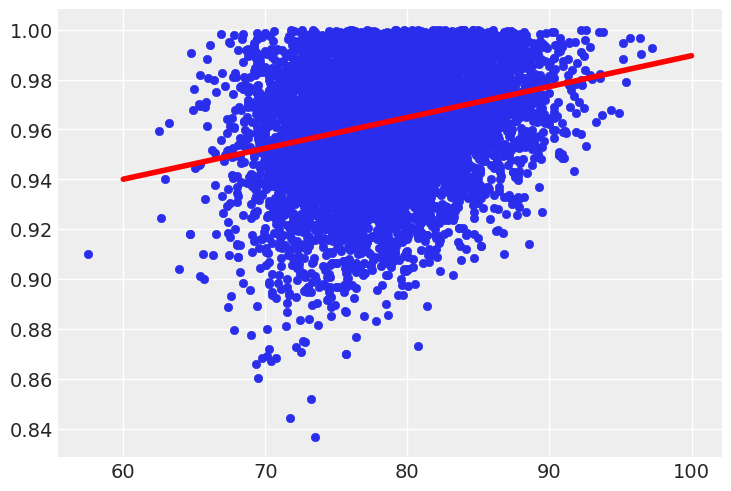

In [130]:
plt.scatter(df_trace['b'], df_trace['phi'])
plt.plot(np.linspace(60,100, 10),results.params[0] + results.params[1] * np.linspace(60,100, 10), color="r");

No significant correlation between b and phi, very low R².

### 2.2.3 Fitting

In [260]:
mu = trace['a'] + trace['b'] * X.reshape(y.shape[0],1) + trace['alpha'].T[np.arange(y.shape[0])%4]

last_err = y[:,0].reshape(y.shape[0],1)[0,:] - mu[0,:]
res = []
res.append(last_err)

for i in range(1, y.shape[0]):
    new_res = trace['phi'] * last_err + np.random.normal(0, np.sqrt(1/trace['tau']))
    res.append(new_res)
    new_err = y[:,0].reshape(y.shape[0],1)[i,:] - (mu[i,:] + new_res)
    last_err = new_err

res = np.asarray(res)
y_pred = mu + res

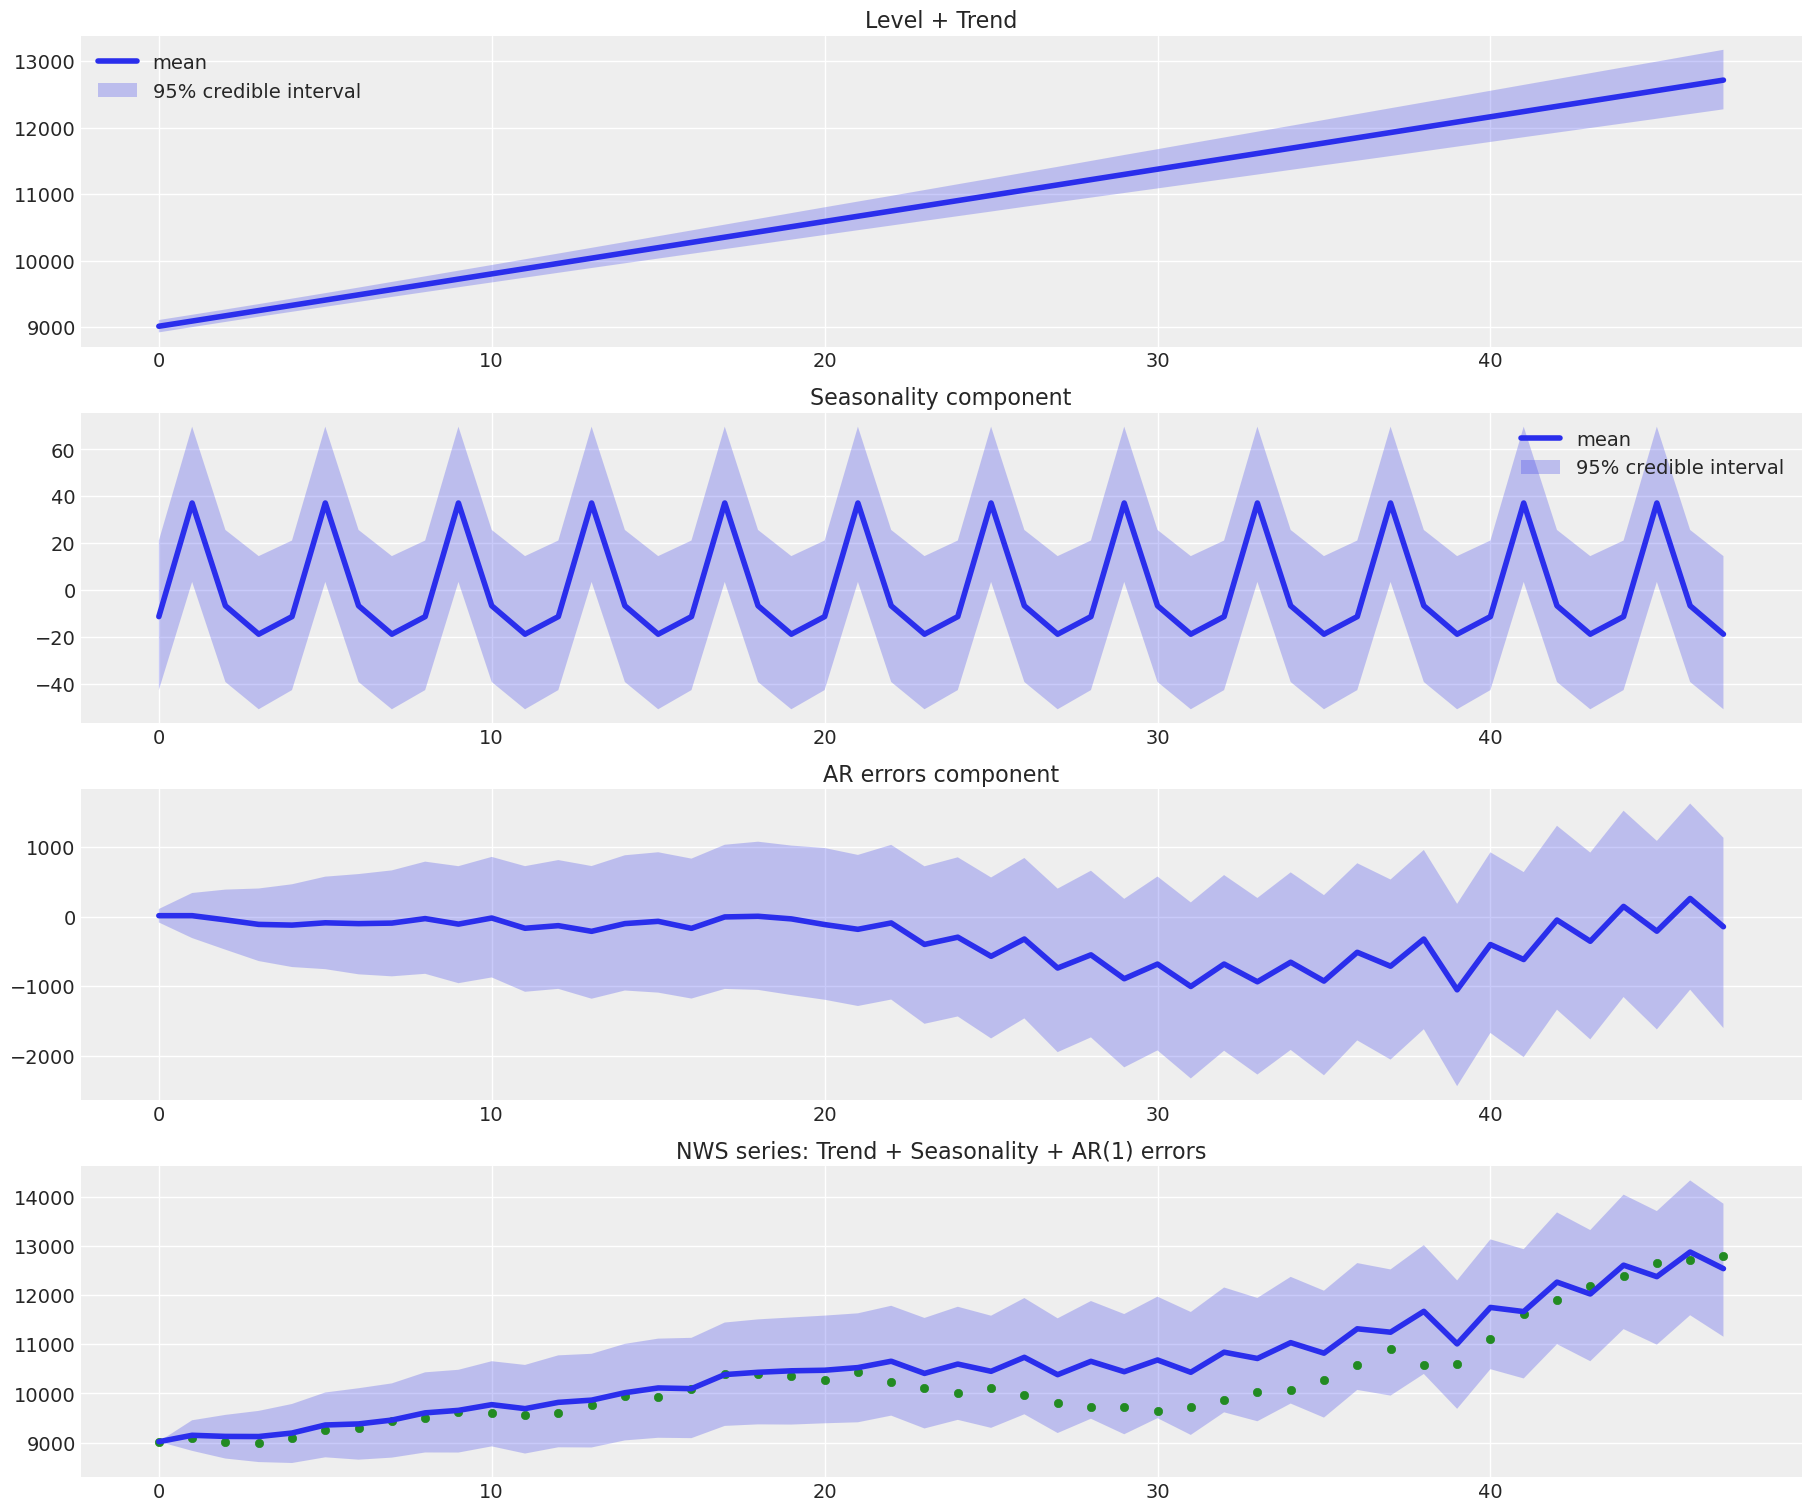

In [261]:
fig, ax = plt.subplots(4, 1, figsize=(18,15))

# Level + Trend

l_t = trace['a'] + trace['b'] * X.reshape(y.shape[0], 1)
CI_l_t = np.percentile(l_t,axis=1,q=[2.5,50, 97.5])
ax[0].plot(CI_l_t[1], label="mean")
ax[0].fill_between(np.arange(y.shape[0]),CI_l_t[0],
                 CI_l_t[2],
                 alpha=0.25,label='95% credible interval')
ax[0].set_title("Level + Trend")
ax[0].legend()

# Seasonality
CI_alpha = np.percentile(trace['alpha'],axis=0,q=[2.5,50, 97.5])
ax[1].plot(CI_alpha[1][np.arange(y.shape[0])%4], label="mean")
ax[1].fill_between(np.arange(y.shape[0]),CI_alpha[0][np.arange(y.shape[0])%4],
                 CI_alpha[2][np.arange(y.shape[0])%4],
                 alpha=0.25,label='95% credible interval')
ax[1].legend()
ax[1].set_title("Seasonality component")

# AR(1) errors
CI_res = np.percentile(res,axis=1,q=[2.5,50, 97.5])

ax[2].plot(CI_res[1], label="mean")
ax[2].fill_between(np.arange(y.shape[0]),CI_res[0],
                 CI_res[2],
                 alpha=0.25,label='95% credible interval')
ax[2].set_title("AR errors component")

# Level + Trend + Seasonality + AR(1) errors
CI_y_pred = np.percentile(y_pred,axis=1,q=[2.5,50, 97.5])

ax[3].plot(CI_y_pred[1], label="mean")
ax[3].fill_between(np.arange(y.shape[0]),CI_y_pred[0],
                 CI_y_pred[2],
                 alpha=0.25,label='95% credible interval')
ax[3].scatter(np.arange(y.shape[0]),y[:,0], color="forestgreen")
ax[3].set_title("NWS series: Trend + Seasonality + AR(1) errors");

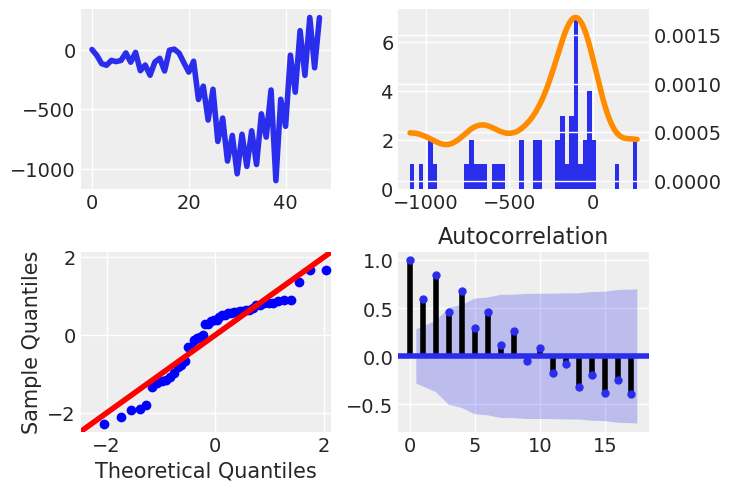

In [262]:
_, ax = plt.subplots(2, 2)

residuals = y[:,0] - CI_y_pred[1] 
ax[0][0].plot(residuals)
ax[0][1].hist(residuals, bins=50)
ax2 = ax[0][1].twinx()
az.plot_kde(residuals, plot_kwargs={'color':'darkorange'},ax = ax2)
stm.graphics.gofplots.qqplot(residuals, fit=True, line="45", ax=ax[1][0])
sm.graphics.tsa.plot_acf(residuals, ax=ax[1][1]);

We need to work on the model, the residuals still show strong autocorrelations and non-normality.

### 2.2.4 Forecasting

In [301]:
n_s = 8000
n = 20      # Forecast horizon
X = np.arange(y.shape[0]+1, n+y.shape[0]+1)

X = np.arange(y.shape[0])
mu = trace['a'] + trace['b'] * X.reshape(y.shape[0],1) + trace['alpha'].T[np.arange(y.shape[0])%4]

last_err = y[:,0].reshape(y.shape[0],1)[-1,:] - mu[-1,:]
forec = np.zeros((n,n_s))

X = np.arange(y.shape[0]+1, n+y.shape[0]+1)
mu = trace['a'] + trace['b'] * X.reshape(n,1) + trace['alpha'].T[np.arange(y.shape[0]+1, n+y.shape[0]+1)%4]

for i in range(0, n):
    forec[i] = trace['phi'] * last_err + np.random.normal(0, np.sqrt(1/trace['tau'])) + mu[i,:]
    new_err = 0
    last_err = new_err

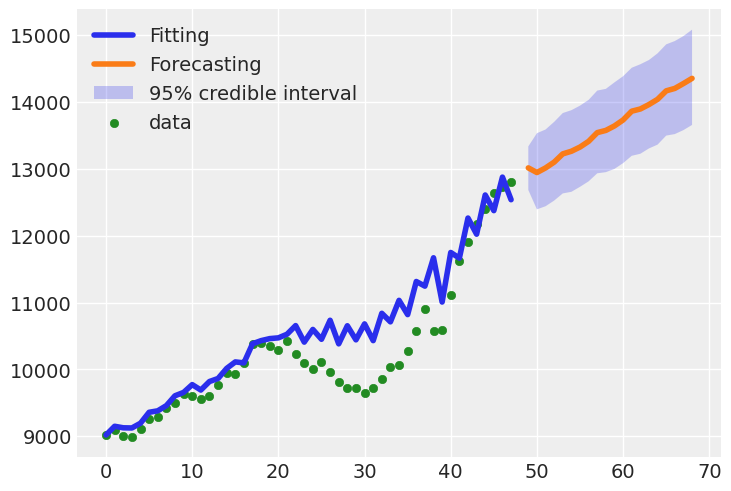

In [305]:
CI_forec = np.percentile(forec, axis=1, q=[2.5, 50, 97.5])

plt.plot(np.arange(y.shape[0]), CI_y_pred[1], label="Fitting")
plt.plot(np.arange(y.shape[0]+1, n+y.shape[0]+1), CI_forec[1], label="Forecasting")
plt.fill_between(np.arange(y.shape[0]+1, n+y.shape[0]+1),CI_forec[0],
                 CI_forec[2],
                 alpha=0.25,label='95% credible interval')
plt.scatter(np.arange(y.shape[0]), y[:,0], color='forestgreen', label="data")

plt.legend();

Uncertainty is constant because we are not adding a stochastic behaviour to our estimations, i.e. level, trend, seasonality are all invariant through time. Next step will be to add that stochastic behaviour to all these components.

# 3. Adding groups 
### 12 series: 3 states, 2 gender and 2 legal

In [420]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')
# Filter first 12 series
y = prison_pivot.loc[:,['NSW', 'WA', 'SA']]

In [421]:
state_idx = pd.get_dummies(
        [i[0] for i in y]
    ).values.argmax(1)

gender_idx = pd.get_dummies(
        [i[1] for i in y]
    ).values.argmax(1)

legal_idx = pd.get_dummies(
        [i[2] for i in y]
    ).values.argmax(1)

In [422]:
state = np.unique(state_idx).shape[0]
gender = np.unique(gender_idx).shape[0]
legal = np.unique(legal_idx).shape[0]

In [423]:
n_series = y.columns.unique().shape[0]
y = y.values
X = np.arange(y.shape[0]).reshape(y.shape[0], 1)

## 3.1 Complete Pooling

##### global level + group effects + global trend + global seasonality + global AR(1) errors


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 45700
Interrupted at 45,699 [22%]: Average Loss = 1.1363e+09
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a3, a2, a1, a0, alpha_pre, tau, phi, b]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 77 seconds.


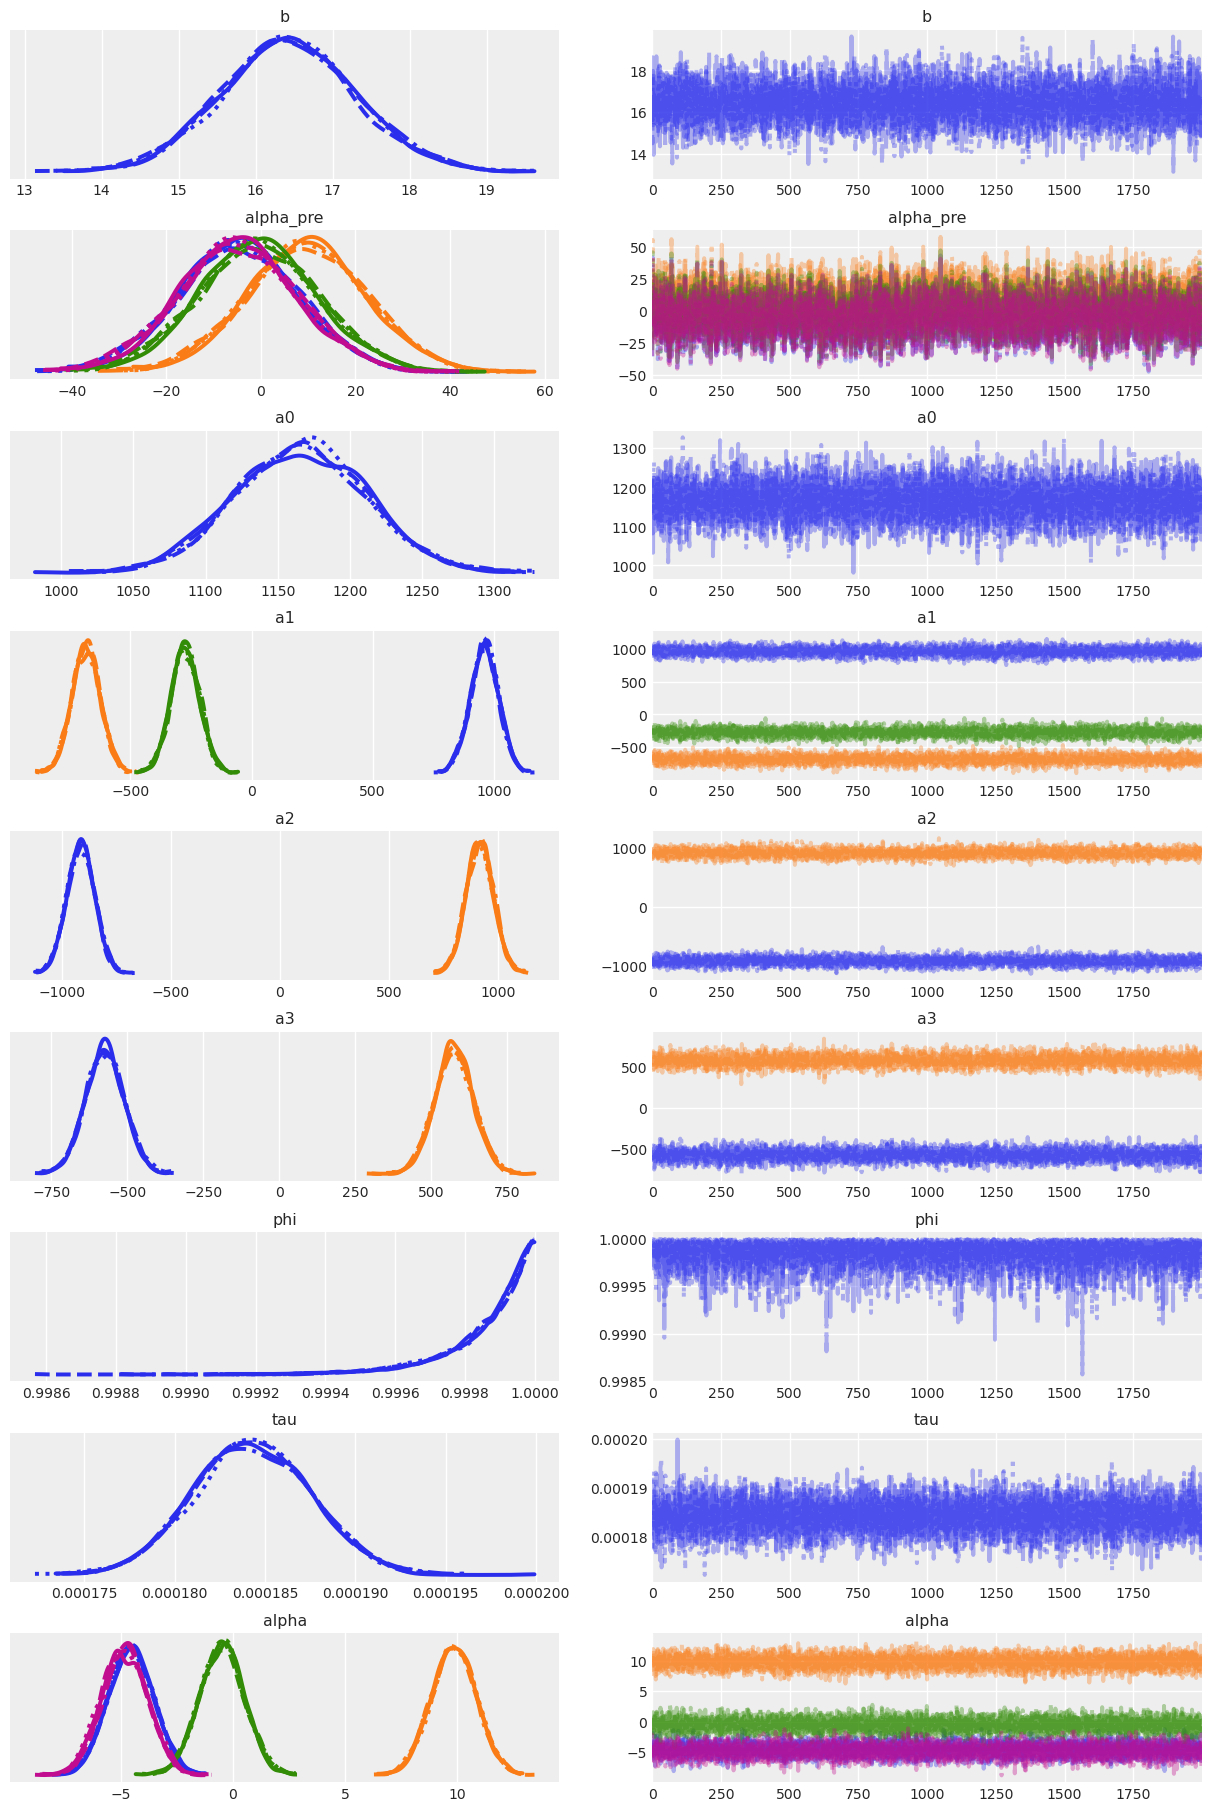

In [450]:
y_ = shared(y)
with pm.Model() as model_pool:
    b = pm.Normal("b",80, 5)

    # Regularizing prior for phi
    phi = pm.Bound(pm.Laplace, lower = -1, upper=1)("phi", 0.0, 0.05)
    tau = pm.HalfNormal("tau", 1)
    
    alpha_pre = pm.Normal('alpha_pre', 0, 25, shape=(4,1))
    alpha = pm.Deterministic('alpha', alpha_pre - tt.mean(alpha_pre,axis=0))
    seasonality = alpha[np.arange(y.shape[0])%4]
    
    a0 = pm.Normal('a0', mu=y[0,:].mean(), sd=50)      
    a1 = pm.Normal('a1', mu=0.0, sd=100, shape=state)
    a2 = pm.Normal('a2', mu=0.0, sd=100, shape=gender)
    a3 = pm.Normal('a3', mu=0.0, sd=100, shape=legal)
            
    mu = (a0 + # global level
          a1[state_idx] + a2[gender_idx] + a3[legal_idx] + # group effects
          X * b + # global trend 
          seasonality) # global seasonality

    err = y_- mu
    y_pred = AR("y_pred", k=phi, tau_e=tau, observed=err) # global AR(1)
    trace_pool = pm.sample(draws=2000, 
                      tune=4000, 
                      init="advi+adapt_diag",
                      target_accept=0.90)

pm.plots.traceplot(trace_pool);

### 3.1.1 Statistical Analysis

##### Compare gender effect

In [451]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((state,gender,legal, n_s))

for (j1,j2,j3) in np.ndindex(state,gender,legal):
        m[j1,j2,j3] =  (trace_pool['a0'] +
                     trace_pool['a1'][:,j1] +
                     trace_pool['a2'][:,j2] +
                     trace_pool['a3'][:,j3])

b0 = np.mean(m, axis=(0,1,2))
b1 = np.mean(m, axis=(1,2)) - b0
b2 = np.mean(m, axis=(0,2)) - b0
b3 = np.mean(m, axis=(0,1)) - b0

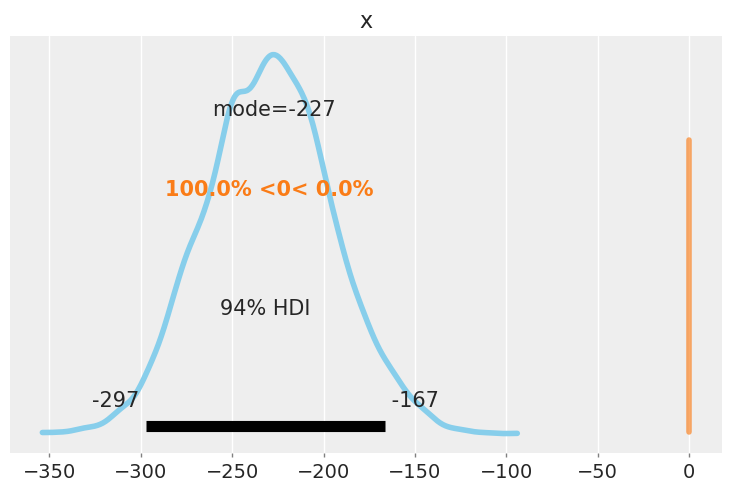

In [464]:
pm.plot_posterior(b2[0,:] - b1[1,:], point_estimate='mode', round_to=0, ref_val=0, color='#87ceeb');

In [453]:
# Baseline
b0.mean()

1169.7152149609617

In [471]:
############# Code adapted from Arviz to calculate mode
# Arviz uses for continuous distributions a kde function to smooth out the histogram and get the local maximum

def histogram(data, bins, range_hist=None):
    """Conditionally jitted histogram.
    Parameters
    ----------
    data : array-like
        Input data. Passed as first positional argument to ``np.histogram``.
    bins : int or array-like
        Passed as keyword argument ``bins`` to ``np.histogram``.
    range_hist : (float, float), optional
        Passed as keyword argument ``range`` to ``np.histogram``.
    Returns
    -------
    hist : array
        The number of counts per bin.
    density : array
        The density corresponding to each bin.
    bin_edges : array
        The edges of the bins used.
    """
    hist, bin_edges = np.histogram(data, bins=bins, range=range_hist)
    hist_dens = hist / (hist.sum() * np.diff(bin_edges))
    return hist, hist_dens, bin_edges

from scipy.signal.windows import gaussian
from scipy.signal import convolve, convolve2d

def _fast_kde(x, cumulative=False, bw=4.5, xmin=None, xmax=None):
    """Fast Fourier transform-based Gaussian kernel density estimate (KDE).
    The code was adapted from https://github.com/mfouesneau/faststats
    Parameters
    ----------
    x : Numpy array or list
    cumulative : bool
        If true, estimate the cdf instead of the pdf
    bw : float
        Bandwidth scaling factor for the KDE. Should be larger than 0. The higher this number the
        smoother the KDE will be. Defaults to 4.5 which is essentially the same as the Scott's rule
        of thumb (the default rule used by SciPy).
    xmin : float
        Manually set lower limit.
    xmax : float
        Manually set upper limit.
    Returns
    -------
    density: A gridded 1D KDE of the input points (x)
    xmin: minimum value of x
    xmax: maximum value of x
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        warnings.warn("kde plot failed, you may want to check your data")
        return np.array([np.nan]), np.nan, np.nan

    len_x = len(x)
    n_points = 200 if (xmin or xmax) is None else 500

    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)

    assert np.min(x) >= xmin
    assert np.max(x) <= xmax

    log_len_x = np.log(len_x) * bw

    n_bins = min(int(len_x ** (1 / 3) * log_len_x * 2), n_points)
    if n_bins < 2:
        warnings.warn("kde plot failed, you may want to check your data")
        return np.array([np.nan]), np.nan, np.nan

    # hist, bin_edges = np.histogram(x, bins=n_bins, range=(xmin, xmax))
    # grid = hist / (hist.sum() * np.diff(bin_edges))

    _, grid, _ = histogram(x, n_bins, range_hist=(xmin, xmax))

    scotts_factor = len_x ** (-0.2)
    kern_nx = int(scotts_factor * 2 * np.pi * log_len_x)
    kernel = gaussian(kern_nx, scotts_factor * log_len_x)

    npad = min(n_bins, 2 * kern_nx)
    grid = np.concatenate([grid[npad:0:-1], grid, grid[n_bins : n_bins - npad : -1]])
    density = convolve(grid, kernel, mode="same", method="direct")[npad : npad + n_bins]
    norm_factor = (2 * np.pi * log_len_x ** 2 * scotts_factor ** 2) ** 0.5

    density /= norm_factor

    if cumulative:
        density = density.cumsum() / density.sum()

    return density, xmin, xmax

In [472]:
density, lower, upper = _fast_kde(b2[0,:] - b1[1,:], bw=4.5)
x = np.linspace(lower, upper, len(density))
mode = x[np.argmax(density)]

In [482]:
print("""The difference between genders is significative (different 
from zero as we can see) and around {} from the baseline. 
The baseline is global constant level of prisoners across states, 
gender and legal status. We can see that female prisoners imply a 
reduction of {} from the baseline {}.""".format(np.round(mode,0), np.round(mode,0), np.round(b0.mean(),0)))

The difference between genders is significative (different 
from zero as we can see) and around -227.0 from the baseline. 
The baseline is global constant level of prisoners across states, 
gender and legal status. We can see that female prisoners imply a 
reduction of -227.0 from the baseline 1170.0.


## 3.2 No Pooling

##### local level + group effects + local trend + local seasonality + local AR(1) errors


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 109500
Interrupted at 109,499 [54%]: Average Loss = 2.3235e+08
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a3, a2, a1, a0, alpha_pre, tau, phi, b]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 1302 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


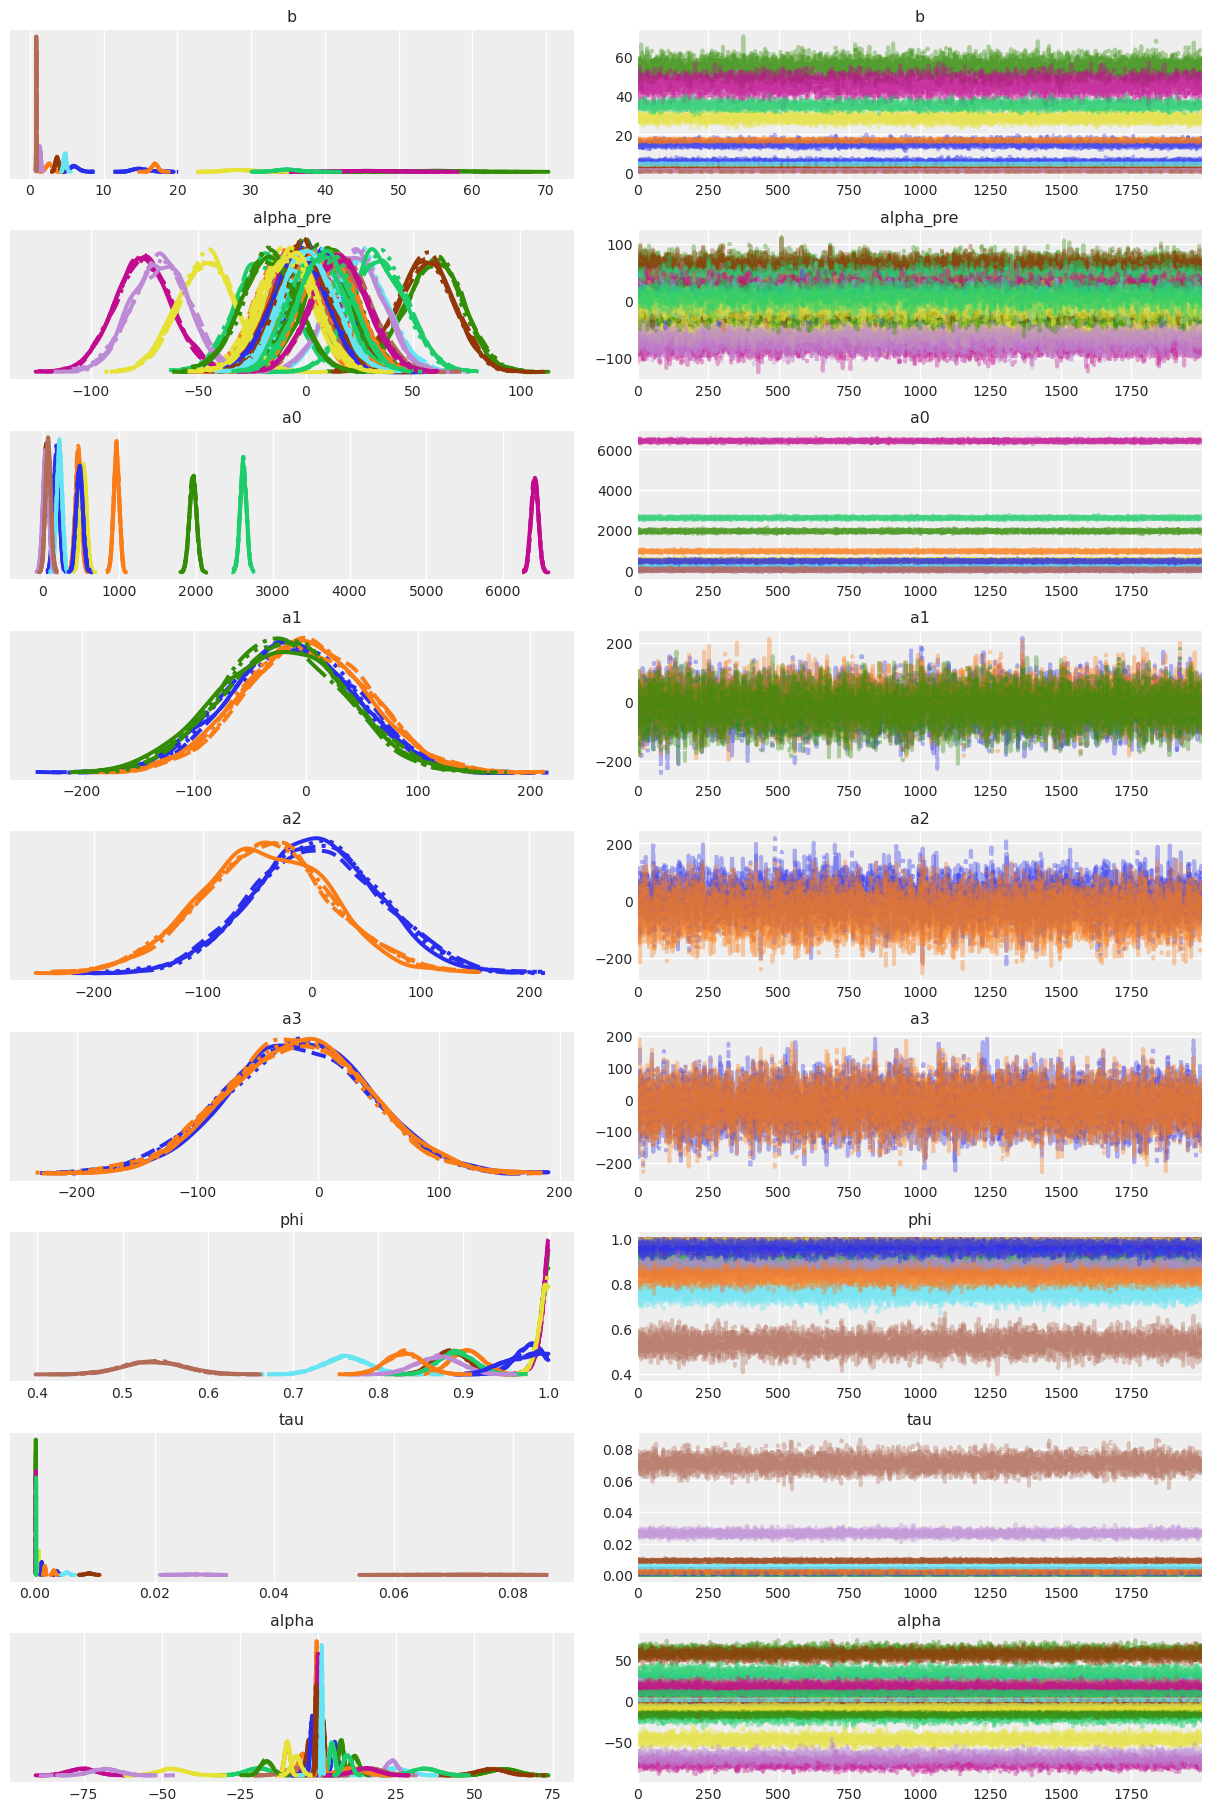

In [469]:
# Local level + group effects + Local trend + seasonality + AR(1) errors

y_ = shared(y)
with pm.Model() as model_unpool:
    b = pm.Normal("b",80, 5, shape=n_series)

    # Regularizing prior for phi
    phi = pm.Bound(pm.Laplace, lower = -1, upper=1)("phi", 0.0, 0.05, shape=n_series)
    tau = pm.HalfNormal("tau", 1, shape=n_series)
    
    alpha_pre = pm.Normal('alpha_pre', 0, 25, shape=(4,n_series))
    alpha = pm.Deterministic('alpha', alpha_pre - tt.mean(alpha_pre,axis=0))
    seasonality = alpha[np.arange(y.shape[0])%4]
    
    a0 = pm.Normal('a0', mu=y[0,:], sd=50, shape=n_series)      
    a1 = pm.Normal('a1', mu=0.0, sd=100, shape=state)
    a2 = pm.Normal('a2', mu=0.0, sd=100, shape=gender)
    a3 = pm.Normal('a3', mu=0.0, sd=100, shape=legal)
            
    mu = (a0 + 
          a1[state_idx] + a2[gender_idx] + a3[legal_idx] + 
          X * b + 
          seasonality)

    err = y_- mu
    y_pred = AR("y_pred", k=phi, tau_e=tau, observed=err)
    trace_unpool = pm.sample(draws=2000, 
                      tune=4000, 
                      init="advi+adapt_diag",
                      target_accept=0.90)

pm.plots.traceplot(trace_unpool);

## 3.3 Partial Pooling

##### global & local level + group effects + global & local trend + global & local seasonality + global & local AR(1) errors

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 55600
Interrupted at 55,599 [27%]: Average Loss = 9.2267e+08
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a3, a2, a1, a0, alpha_pre, tau, phi, b, hy_a0_mu, hy_alpha_pre_mu, hy_phi_mu, hy_b_mu]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 1574 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


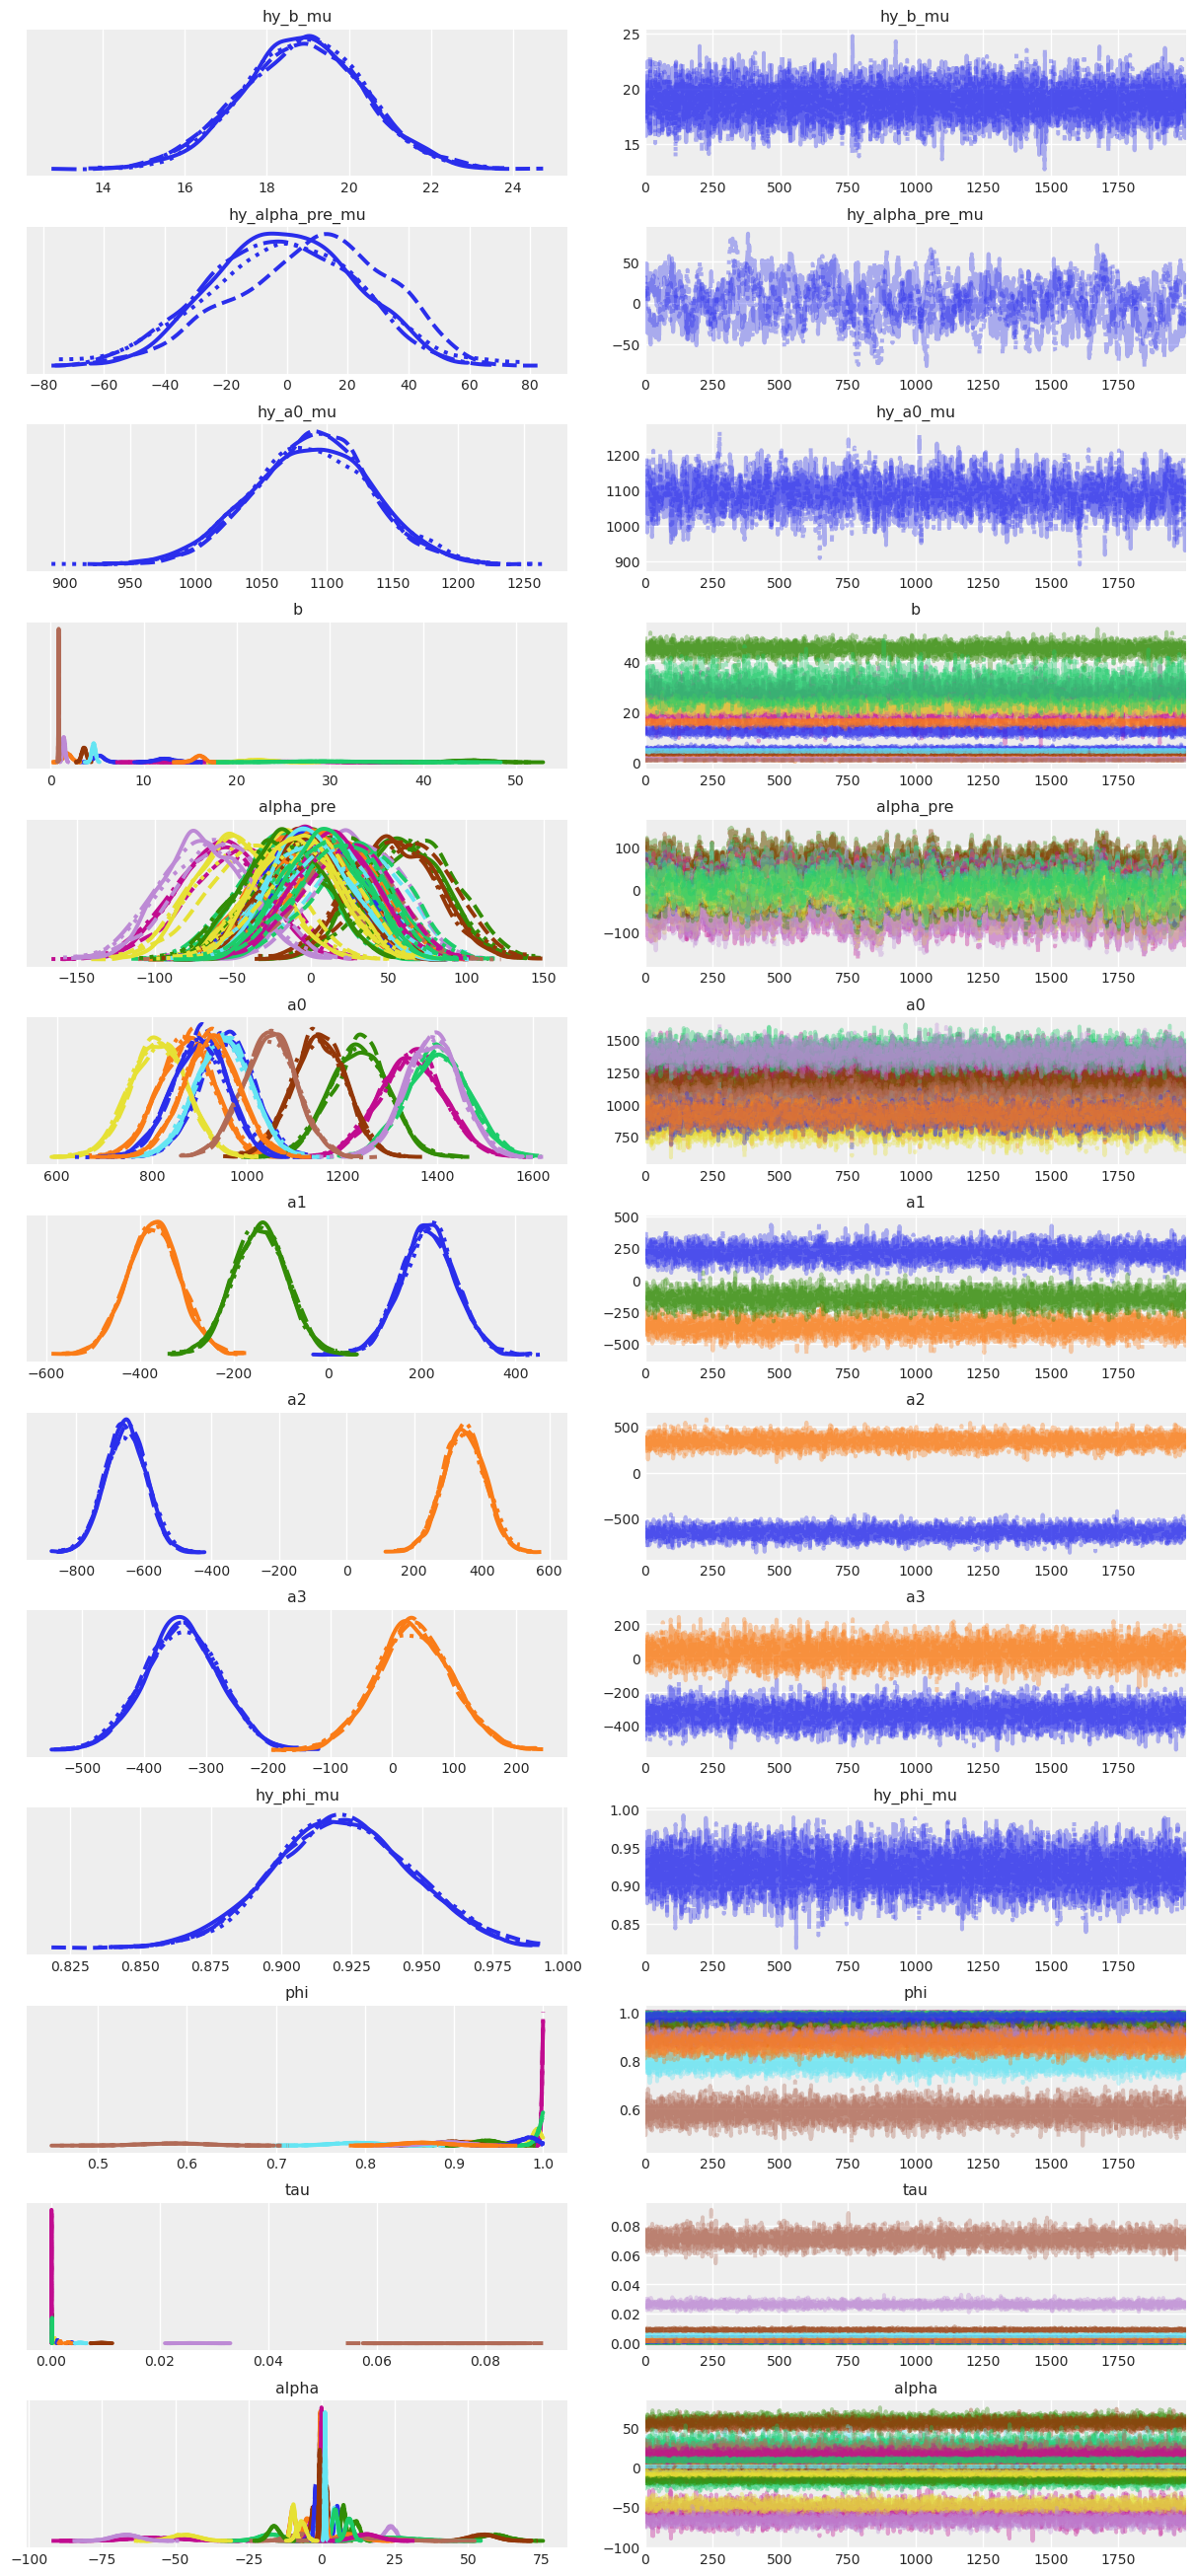

In [470]:
y_ = shared(y)
with pm.Model() as model_p_pool:
    
    # Hyperpriors
    hy_b_mu = pm.Normal("hy_b_mu",80, 5)
    hy_phi_mu = pm.Bound(pm.Laplace, lower = -1, upper=1)("hy_phi_mu", 0.0, 0.05)
    # add one for tau
    hy_alpha_pre_mu = pm.Normal("hy_alpha_pre_mu", 0, 25)
    hy_a0_mu = pm.Normal('hy_a0_mu', mu=y[0,:].mean(), sd=50)
    
    # Adaptative priors
    b = pm.Normal("b",hy_b_mu, 5, shape=n_series)
    # Regularizing prior for phi
    phi = pm.Bound(pm.Laplace, lower = -1, upper=1)("phi", hy_phi_mu, 0.05, shape=n_series)
    tau = pm.HalfNormal("tau", 1, shape=n_series)
    
    alpha_pre = pm.Normal('alpha_pre', hy_alpha_pre_mu, 25, shape=(4, n_series))
    alpha = pm.Deterministic('alpha', alpha_pre - tt.mean(alpha_pre,axis=0))
    seasonality = alpha[np.arange(y.shape[0])%4]
    
    a0 = pm.Normal('a0', mu=hy_a0_mu, sd=50, shape=n_series)      
    a1 = pm.Normal('a1', mu=0.0, sd=100, shape=state)
    a2 = pm.Normal('a2', mu=0.0, sd=100, shape=gender)
    a3 = pm.Normal('a3', mu=0.0, sd=100, shape=legal)
          
    
    # AR(1) errors
    mu = (a0 + 
          a1[state_idx] + a2[gender_idx] + a3[legal_idx] + 
          X * b + 
          seasonality)

    err = y_- mu
    y_pred = AR("y_pred", k=phi, tau_e=tau, observed=err)
    trace_p_pool = pm.sample(draws=2000, 
                      tune=4000, 
                      init="advi+adapt_diag",
                      target_accept=0.90)

pm.plots.traceplot(trace_p_pool);

### 3.3.1 Partial Pooling using VAR

##### global & local level + group effects + global & local trend + global & local seasonality + global & local VAR(1) errors

In [ ]:
import numpy as np
import theano.tensor as tt
from pymc3.distributions.continuous import get_tau_sigma, Normal, Flat
from pymc3.distributions import distribution

class VAR(distribution.Continuous):
    """
    Vector Autoregressive process with p lags for s series with estimated interdependencies between series
    
    Parameters
    ----------
    rho : tensor
       shape is [p lags, s series, s_series]
    
    constant: tensor
        shape is s series

    """
    
    @staticmethod
    def as_array_with_shape(x):
        if isinstance(x, list):
            x = np.array(x)
        try:
            shape = x.shape.tag.test_value
        except AttributeError:
            shape = x.shape
        return x, shape
        

    def __init__(self, rho, sigma=None, tau=None,
                 constant=False, init=Flat.dist(),
                 sd=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if sd is not None:
            sigma = sd

        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)

        self.mean = tt.as_tensor_variable(0.)
        
        rho, rho_shape_ = self.as_array_with_shape(rho)
        assert len(rho_shape_) == 3, 'rho must be three dimensional array or RV'
        assert rho_shape_[1] == rho_shape_[2], 'rho must contain same len in dim 2 and 3'
        
        self.p = rho_shape_[0]
        self.nseries = rho_shape_[1]
        
        if constant is not False:
            constant, constant_shape_ = self.as_array_with_shape(constant)
            assert len(constant_shape_) == 1, 'constant must be one dimmensional array or RV'
            assert constant_shape_[0] == self.nseries, 'constant must be same length as rho dim 1 and 2'
            constant = tt.as_tensor_variable(constant)

        self.constant = constant
        self.rho = rho = tt.as_tensor_variable(rho)
        self.init = init

    def logp(self, value):
        """
        Calculate log-probability of VAR distribution at specified value.
        Parameters
        ----------
        value : numeric
            Value for which log-probability is calculated.
        Returns
        -------
        TensorVariable
        """
 
        x_s = []
        for s in range(self.nseries):
            s_stacked = tt.stack([value[:,s] for i in range(self.nseries)], axis=1)
            x_s.append(tt.add(*[self.rho[i, s, :] * s_stacked[self.p - (i + 1):-(i + 1)] for i in range(self.p)]))
        x = tt.add(*x_s)
        
        if self.constant is not False:
            x += self.constant
            
        eps = value[self.p:] - x

        innov_like = Normal.dist(mu=0.0, tau=self.tau).logp(eps)
        init_like = self.init.logp(value[:self.p])

        return tt.sum(innov_like) + tt.sum(init_like)

In [ ]:
y_ = shared(y)
with pm.Model() as model_p_pool_VAR:
    
    # Hyperpriors
    hy_b_mu = pm.Normal("hy_b_mu",80, 5)
    hy_phi_mu = pm.Bound(pm.Laplace, lower = -1, upper=1)("hy_phi_mu", 0.0, 0.05)
    # add one for tau
    hy_alpha_pre_mu = pm.Normal("hy_alpha_pre_mu", 0, 25)
    hy_a0_mu = pm.Normal('hy_a0_mu', mu=y[0,:].mean(), sd=50)
    
    # Adaptative priors
    b = pm.Normal("b",hy_b_mu, 5, shape=n_series)
    # Regularizing prior for phi
    phi = pm.Bound(pm.Laplace, lower = -1, upper=1)("phi", hy_phi_mu, 0.05, shape=(1, n_series,n_series))
    tau = pm.HalfNormal("tau", 1, shape=n_series)
    
    alpha_pre = pm.Normal('alpha_pre', hy_alpha_pre_mu, 25, shape=(4, n_series))
    alpha = pm.Deterministic('alpha', alpha_pre - tt.mean(alpha_pre,axis=0))
    seasonality = alpha[np.arange(y.shape[0])%4]
    
    a0 = pm.Normal('a0', mu=hy_a0_mu, sd=50, shape=n_series)      
    a1 = pm.Normal('a1', mu=0.0, sd=100, shape=state)
    a2 = pm.Normal('a2', mu=0.0, sd=100, shape=gender)
    a3 = pm.Normal('a3', mu=0.0, sd=100, shape=legal)
          
    
    # AR(1) errors
    mu = (a0 + 
          a1[state_idx] + a2[gender_idx] + a3[legal_idx] + 
          X * b + 
          seasonality)

    err = y_- mu
    y_pred = VAR("y_pred", k=phi, tau_e=tau, observed=err)
    trace_p_pool_VAR = pm.sample(draws=2000, 
                      tune=4000, 
                      init="advi+adapt_diag",
                      target_accept=0.90)

pm.plots.traceplot(trace_p_pool_VAR);

# Next steps:

1. Test non-linear effects between groups
3. Test stochasticity of trend and seasonality
4. Test multivariate normal to allow parameters to covary